# GENFI project
**Date:** 2/08/2023

**Author:** Dr. Siddharth Ramanan, MRC Cognition and Brain Sciences Unit, University of Cambridge, UK

## Project details

**Overall aims and methods:** Examine cognitive, clinical and behavioural heterogeneity in frontotemporal dementia gene carriers

**People involved:** Siddharth Ramanan (lead), Danyal Akarca, Shalom Henderson, Matthew Rouse, Karalyn Patterson, James B. Rowe, Matthew A. Lambon Ralph + GENFI collaborators

**Dataset description:** Data are from Data Freeze 6. Having a quick look at the Excel files that James has emailed over (22/6/23), there are 5 data files in total:
- Biosamples
- Clinical
- Demographics
- Imaging
- Neuropsychology

**Data dictionary:** There doesn't seem to be one. There are legends and codes embedded in the excel sheet (e.g., if 0 then presymptomatic, etc.) but these aren't being read properly into the df. Best to document these as we go.

**Issues to be aware of:**

**Location of files:** C:\Users\sr06\ownCloud\Projects\In Progress\GENFI_JBR. This link contains subfolders for:
- Code
- Data
- Data request form
- Manuscript and figures

**Location of python environment:** All respective packages for this project are installed in C:\Users\sr06\ownCloud\Projects\In Progress\myenv\Lib\site-packages. A kernel called mykernel has been created with all relevant packages installed. The environment is called "myenv" and must be loaded prior to running the code, using conda activate myenv

## Read data and load relevant packages

I load python and R packages as I will be using both languages within this jupyter notebook.

In [98]:
# load relevant python libraries

# analysis
import numpy as np # import numpy
import pandas as pd # import pandas library for data wrangling
import random # import random library
import sklearn as sklearn # import sklearn library
from sklearn.decomposition import * # dependencies that we will need for scaling data, PCA etc.
from sklearn.preprocessing import * # dependencies that we will need for scaling data, PCA etc.
from sklearn.preprocessing import StandardScaler # for scaling data for PCA
from sklearn.decomposition import PCA # PCA
import miceforest as mf # import miceforest for imputation
from miceforest import (mean_match_default, mean_match_fast_cat, mean_match_shap) # predictive mean matching options in mice
from advanced_pca import CustomPCA # varimax PCA
from factor_analyzer import * # import varimax PCA, KMO etc.
import TVGL as tvgl # time varying graphical modelling

# data viz
import matplotlib # import matplotlib library for plotting
from matplotlib import pyplot as plt # import pyplot from matplotlib library for plotting
import plotnine as p9 # plotting ggplot-style
from plotnine import ggplot, aes, geom_point, geom_text, geom_hline, geom_vline, labs, xlim, ylim, geom_abline, annotate, geom_path, geom_tile
from plotnine import *
import patchworklib as pw # multiplot
import seaborn as sns # import seaborn for plotting
from IPython.display import display #  for displaying data
from adjustText import adjust_text # repel labels

# adjustments to visualising within this notebook
%matplotlib inline
pd.options.display.max_columns = None # to show all cols when viewing data
plt.rcParams['figure.figsize'] = [20, 20] # increase size of plots within Jupyter notebook (this may still cut out some data for inline viz)

In [144]:
# bring in relevant R packages into this environment (loaded separately in next code chunk using %%R magic)
# R 
%load_ext rpy2.ipython
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import rpy2.robjects.packages as rpackages 
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
from rpy2.robjects import pandas2ri
pandas2ri.activate() #Must be activated
utils = rpackages.importr("utils") # import utils package
utils.chooseCRANmirror(ind=1) # choose importing mirror
package_names = ("base", "stats", "psych", "lme4", "tidyverse", "reshape2", "GPArotation") # set package names to be installed

if all(rpackages.isinstalled(x) for x in package_names):
    have_package = True
    
else: 
    have_package = False
    
if not have_package:
    
    utils = rpackages.importr("utils")
    utils.chooseCRANmirror(ind=1)
    
    packnames_to_install = [x for x in package_names if not rpackages.isinstalled(x)]
    
    if len(packnames_to_install) > 0:
        utils.install_packages(StrVector(packnames_to_install))

        utils.install_packages(StrVector(package_names))
psych = rpackages.importr("psych") # psych package
GPArotation = rpackages.importr("GPArotation") # psych package dependency for PCA
base = rpackages.importr("base") # import base package
stats = rpackages.importr("stats") # stats package
lme4 = rpackages.importr("lme4") # lme4 package
tidyverse = rpackages.importr("tidyverse") # tidyverse package
reshape2 = rpackages.importr("reshape2") # reshape2 package

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [143]:
%%R
install.packages("psych", repos="http://cran.us.r-project.org", quiet=TRUE) # install psych
install.packages("ggplot2", repos="http://cran.us.r-project.org", quiet=TRUE) # install ggplot2
install.packages("lme4", repos="http://cran.us.r-project.org", quiet=TRUE) # install lme4
install.packages("GPArotation", repos="http://cran.us.r-project.org", quiet=TRUE) # install GPA rotation
install.packages("base", repos="http://cran.us.r-project.org", quiet=TRUE) # install base
install.packages("stats", repos="http://cran.us.r-project.org", quiet=TRUE) # install stats
install.packages("tidyverse", repos="http://cran.us.r-project.org", quiet=TRUE) # install tidyverse
install.packages("reshape2", repos="http://cran.us.r-project.org", quiet=TRUE) # install reshape2

Having a quick look at the Excel files from data freeze 6 that James has emailed over (22/6/23), there are 5 data files in total:
- Biosamples
- Clinical
- Demographics
- Imaging
- Neuropsychology

Each of these Excel files has two sheets (GENFI1 and GENFI2) corresponding to each wave of the GENFI, with the same colnames. When I looked at some of the IDs (e.g., GRN161) they have different dates of assessment between GENFI1 and GENFI2 which leads me to believe that GENFI2 is an extension of GENFI1, with no replication of time-stamped data between these two sheets. I will import both sheets and concatenate them together. Where Visit values < 10, source is GENFI1 else GENFI2. Later, I'll repeat these steps for other variables and then left join them with genfi_dem as and when needed.

In [ ]:
# I will import all the five datasets, concatenate across GENFI1 & GENFI2 sheets and then left_join them.

# demographics data
all_genfi_dem = pd.read_excel("../Data/FINAL_BLINDED_GENFI_DEMOGRAPHICS_DF6.xlsx", sheet_name=None)

# clinical data
all_genfi_clinical = pd.read_excel("../Data/FINAL_BLINDED_GENFI_CLINICAL_DF6.xlsx", sheet_name=None)

# neuropsych data
all_genfi_neuropsy = pd.read_excel("../Data/FINAL_BLINDED_GENFI_NEUROPSYCH_DF6.xlsx", sheet_name=None)

# imaging data
all_genfi_imaging = pd.read_excel("../Data/FINAL_BLINDED_GENFI_IMAGING_DF6.xlsx", sheet_name=None)

# biosamples data
all_genfi_biosamp = pd.read_excel("../Data/FINAL_BLINDED_GENFI_BIOSAMPLES_DF6.xlsx", sheet_name=None)

In [ ]:
# for all dfs, check if both sheets are read in
all_genfi_dem.keys()
all_genfi_clinical.keys()
all_genfi_neuropsy.keys()
all_genfi_imaging.keys()
all_genfi_biosamp.keys()

In [ ]:
# For all dfs, concatenate both sheets into one df

# demographics
genfi_dem = pd.concat(all_genfi_dem, ignore_index=True)
genfi_dem.head(20)
# to visualise the full dataset, use the code below but be aware it is computationally expensive.
#pd.options.display.max_columns = None
#pd.options.display.max_rows = None
#display(genfi_dem)

In [ ]:
# clinical
genfi_clinical = pd.concat(all_genfi_clinical, ignore_index=True)
genfi_clinical.head(20)

In [ ]:
# neuropsych
genfi_neuropsy = pd.concat(all_genfi_neuropsy, ignore_index=True)
genfi_neuropsy.head(20)

In [ ]:
# imaging
genfi_imaging = pd.concat(all_genfi_imaging, ignore_index=True)
genfi_imaging.head(20)

In [ ]:
# biosamples
genfi_biosamp = pd.concat(all_genfi_biosamp, ignore_index=True)
genfi_biosamp.head(20)

## Data cleaning and organising

All data frames have been read in. As the focus of this study is on clinical and neuropsych vars, I will now merge the clinical and neuropsych data with the demographic data. Once I've decided which pts to keep, I will then left_join the imaging and biosamples data.

In [ ]:
# calling this df as genfi_behav (for all behavioural data)
# first, I merge demographic and clinical data
genfi_demclin = pd.merge(genfi_dem, 
                         genfi_clinical, 
                         how="left", 
                         left_on=["Blinded Code", "Visit"], 
                         right_on=["Blinded Code", "Visit"], 
                         suffixes=('', '_y'));

# merge neuropsych data
genfi_behav = pd.merge(genfi_demclin, 
                       genfi_neuropsy, 
                       how="left", 
                       left_on=["Blinded Code", "Visit"], 
                       right_on=["Blinded Code", "Visit"], 
                       suffixes=('', '_z'));

# remove duplicated columns (indicated by suffixes _y and _z)
genfi_behav.drop(genfi_behav.filter(regex='_y$').columns, axis=1, inplace=True)
genfi_behav.drop(genfi_behav.filter(regex='_z$').columns, axis=1, inplace=True)

# extract colnames to see if everything aligns ok
column_names = list(genfi_behav)
column_names

A number of variables such as Genetic status, Mother/Father affected need to be recoded in the data frame. Doing that below using the keys detailed within the first 4 rows of the dataset.

In [ ]:
# extract the first four rows to understand which cols need recoding
genfi_behav.head(20)

In [ ]:
# first make a copy of the df genfi_behav_drop so that the original is not altered everytime we make a change in the copy
genfi_behav_drop1 = genfi_behav.copy()

# the keys for many variables are stored in both the first 4 and last 4 rows
# drop the first 4 rows and the last 4 rows of the df so recoding becomes easier
genfi_behav_drop2 = genfi_behav_drop1.iloc[4:]
genfi_behav_dropkey1 = genfi_behav_drop2.iloc[:-4]
len(genfi_behav_dropkey1)

# make a copy of the genfi_behav_dropkey df that we can modify it safely without impacting the previous version
genfi_behav_dropkey = genfi_behav_dropkey1.copy()

### Recoding variables

Now, I recode some of these variables so they are easier to work with in the future.

In [193]:
# in this new dropkey df, recode the following vars:
# note that it will produce a standard warning as you are replacing the value in the df using "inplace"

# recode Genetic Status 1
genfi_behav_dropkey['Genetic status 1'].replace(["P", "A"], ['At-risk', "Symptomatic"], inplace=True)

# recode Genetic Status 2 (per JBR mail on 11/7/23, the code for 0,1,2 are described below)
genfi_behav_dropkey['Genetic status 2'].replace([0, 1, 2], ['Non-carrier', "Carrier-asymptomatic", "Carrier-symptomatic"], inplace=True)

# recode Awareness of Genetic Status
genfi_behav_dropkey["Awareness of genetic status"].replace([0, 1, 99], ["Not aware", "Aware", np.NaN], inplace=True)

# recode Mother Affected
genfi_behav_dropkey['Mother Affected'].replace([1, 0], ['Affected', "Unknown"], inplace=True)

# recode Father Affected
genfi_behav_dropkey['Father Affected'].replace([1, 0], ['Affected', "Unknown"], inplace=True)

# recode Age at Death
genfi_behav_dropkey['AAD'].replace(2, np.NaN, inplace=True)
# do a backfill (fill="up") as for some (e.g., GRN001), their age of death is reflected only in their last data point
genfi_behav_dropkey["AAD"] = genfi_behav_dropkey.groupby("Blinded Code")["AAD"].bfill()

# recode Gender
genfi_behav_dropkey['Gender'].replace([0, 1], ['Female', "Male"], inplace=True)

# recode Handedness
genfi_behav_dropkey['Handedness'].replace([0, 1, 2], ["Right", "Left", "Ambidextrous"], inplace=True)

# recode bvFTD criteria
genfi_behav_dropkey['Rascovsky'].replace([1, 2], ['Probable', "Possible"], inplace=True)

# recode PPA criteria
genfi_behav_dropkey['Gorno-Tempini'].replace([1, 2, 3, 4], ['PPA-NOS', "nfvPPA", "svPPA", "lvPPA"], inplace=True)

# recode ALS criteria
genfi_behav_dropkey['El-Escorial'].replace([-1, 1, 2, 3, 4], [np.NaN, "Definite", "Probable", "Lab-supported", "Possible"], inplace=True)

# recode Seizures
genfi_behav_dropkey['Seizures'].replace([1, 2], ['Recent/active', "Possible"], inplace=True)

# FCSRT is coded as FCRST so fix this
genfi_behav_dropkey.rename(columns={"FCRST_del_free": "FCSRT_del_free", "FCRST_del_total", "FCSRT_del_total", "FCRST_free", "FCSRT_free", "FCRST_total", "FCSRT_total"}, inplace= True)

# Create a source column to know which participants are from GENFI wave 1 vs. wave 2
# All GENFI2 participants have their Visit coded as double digits so I use this as a marker
genfi_behav_dropkey['Source'] = np.where(genfi_behav_dropkey['Visit'] > 10, 'GENFI2', 'GENFI1');

# I will also rename the Blinded Code column to ID and Visit to VisitNumber so I can later create another Visit column that labels each visit as a single numeric value grouped within ID
genfi_behav_dropkey.rename(columns={"Blinded Code": "ID", "Visit": "VisitNumber"}, inplace=True)

# now I create a new column called Visit where I create a cumulative count of each row grouped within ID
genfi_behav_dropkey["Visit"] = genfi_behav_dropkey.groupby("ID").cumcount()+1

# also create a lag count for the number of days between consecutive assessments so that I can find IDs who visit after a long break
genfi_behav_dropkey["Date of assessment"] = pd.to_datetime(genfi_behav_dropkey["Date of assessment"])

genfi_behav_dropkey["LagDaysBwAx"] = (genfi_behav_dropkey.groupby("ID")["Date of assessment"]
                                     .diff()
                                     .dt.days
                                     .fillna(0, downcast="int"))

SyntaxError: invalid syntax (3389666443.py, line 43)

There are three columns called First symptoms 1,2,3. The values here are coded alphanumerically. The corresponding codes for these are assigned to clinical symptoms such as Disinhibition (B1), Apathy (B2) etc. To replace these first symptom codes with the actual string values, I will create a dictionary which will make substitution easier.

In [ ]:
# create dictionary of symptoms
genfi_dict_sx = {"B1": "Disinhibition",
                "B2": "Apathy",
                "B3": "Empathy",
                "B4": "OCD",
                "B5": "Appetite",
                "B6": "Emotions",
                "B7": "Trusting",
                "C1": "Vis. Hallucinations",
                "C2": "Aud. Hallucinations",
                "C3": "Tact. Hallucinations",
                "C4": "Delusions",
                "C5": "Depression",
                "C6": "Anxiety",
                "C7": "Lability",
                "C8": "Aggression",
                "C9": "Euphoria",
                "C10": "Aberr. Motor",
                "C11": "Hypersexuality",
                "C12": "Hyperreligiousity",
                "C13": "Sleep",
                "C14": "Humour", 
                # language disturbances
                "D1": "Articulation",
                "D2": "Fluency",
                "D3": "Grammar",
                "D4": "Retrieval",
                "D5": "Repetition",
                "D6": "Sent. Comprehension",
                "D7": "Word Comprehension",
                "D8": "Dyslexia",
                "D9": "Dysgraphia",
                "D10": "Func. Communication",
                # cognitive disturbances
                "E1": "Memory",
                "E2": "Orientation", 
                "E3": "Judg/Prob. Solv.",
                "E4": "Comm. Affairs",
                "E5": "Hobbies",
                "E6": "Personal Care",
                "E7": "Person Recogn.",
                "E8": "Topog. Memory",
                "E9": "Visuospatial",
                "E10": "Attention",
                "E11": "Bradyphrenia",
                # motor disturbances
                "F1": "Dysarthria",
                "F2": "Dysphagia",
                "F3": "Tremor",
                "F4": "Slowness",
                "F5": "Weakness",
                "F6": "Gait",
                "F7": "Falls",
                "F8": "Hands",
                # autonomic
                "G1": "BP",
                "G2": "Gastro",
                "G3": "Thermo",
                "G4": "Urinary",
                "G5": "Pain",
                "H1": "Sounds",
                "H2": "Smell",
                "H3": "Unexplained",
                "H4": "Breathing"
                }

# now replace First symptom, First symptom.1 and First symptom.2 cols with these dictionary values
genfi_behav_dropkey["First symptom"].replace(genfi_dict_sx, inplace=True)
genfi_behav_dropkey["First symptom.1"].replace(genfi_dict_sx, inplace=True)
genfi_behav_dropkey["First symptom.2"].replace(genfi_dict_sx, inplace=True)

# View these changes to see if they have taken place
genfi_behav_dropkey.head(20) # looks like it worked!

# If needed, sort this data into a new df to arrange data by ID and visit to check if data looks OK
#genfi_behav_dropkey_sorted = genfi_behav_dropkey.sort_values(['ID', 'Visit'], ascending=True)

I now examine how many IDs have more than 3 occurrences as I want keep those IDs that have more than 2 longitudinal time point data.

In [ ]:
genfi_behav_dropkey["Total"] = genfi_behav_dropkey.groupby("ID")["ID"].transform('count')

# plot these values
plt.hist(genfi_behav_dropkey["Total"], bins=8)
plt.axvline(x=3, color = "red")

From the plot above, it looks like some 900+ data points that have 2+ occurrences. I have drawn a vertical red line at 3 to show the number of data points that have 3 and + occurrences. I now use the LagDaysBwAx variable to examine the gap between consecutive assessments for each person. This will reveal patients who are visiting after a long break. I make this plot by ID and by genetic group.

In [ ]:
# for each ID
sns.lineplot(data=genfi_behav_dropkey, x="Visit", y="LagDaysBwAx", hue="ID", legend=False) # removing the legend otherwise it'll produce one for every ID

In [ ]:
# by genetic group
sns.lineplot(data=genfi_behav_dropkey, x="Visit", y="LagDaysBwAx", hue="Genetic Group")

In [ ]:
# lets examine what the data look like if I look only within GENFI2, where there have been more regular followups
genfi_behav_dropkey_GENFI2 = genfi_behav_dropkey[genfi_behav_dropkey["Source"] == "GENFI2"]

# plot a line graph
sns.lineplot(data=genfi_behav_dropkey_GENFI2, x="Visit", y="LagDaysBwAx", hue="ID", legend=False)

These above plots are super helpful but before I proceed with selecting which patients to keep for the analyses, I need to understand the overall nature of missing data there are.

### Missing data visualisation in full dataset

The next step is to examine how many missing data there are for the neuropsych variables for all patients across GENFI1 and GENFI2. This will help me understand whether I should analyse GENFI1 also or just focus on GENFI2. I will create a copy of my df, keep mainly the neuropsych variables, recode them as Missing or Present, stratify the dataset by Source, and make a raster plot (as a side note, selecting both single and a range of cols together seems incredibly complicated in Pandas as opposed to Tidyverse...).

In [ ]:
# select the vars of interest and save it as a copy of the df
genfi_behav_dropkey_missingInspection = genfi_behav_dropkey.copy()

# create a list of columns that you want to keep (there may be a faster way to index single and a range of cols together)
cols = genfi_behav_dropkey_missingInspection.columns.values

# alter this list to keep only the cols of interest
cols = ['ID', 'Source', 'Visit', 'Affected.1', 'Disinhibition', 'Apathy', 'Empathy',
       'OCD', 'Appetite', 'Affected.2', 'Vis_hal', 'Aud_hal', 'Tac_hal',
       'Delusions', 'Depression', 'Anxiety', 'Affected.3', 'Artic',
       'Fluency', 'Grammar', 'Retrieval', 'Repetition', 'Sent_comp',
       'Word_comp', 'Dyslexia', 'Dysgraphia', 'Func_comm', 'Affected.4',
       'Memory', 'Visuospatial', 'Judg_prob_solv', 'Attention',
       'Affected.5', 'Dysarthria', 'Dysphagia', 'Tremor', 'Slowness',
       'Weakness', 'Gait', 'Falls', 'Seizures', 'Stroke', 'TBI',
       'Hypertension', 'Hyperchol', 'Diabetes', 'EMG', 'Supranuclear',
       'Bulbar', 'Pseudobulbar', 'Myoclonus', 'Rest_tremor',
       'Post_tremor', 'Dystonia', 'Bradykinesia', 'Rigidity',
       'Limb_apraxia', 'Alien_limb', 'Fascic_UL', 'Fascic_LL',
       'Spasticity_UL', 'Spasticity_LL', 'Weakness_UL', 'Weakness_LL',
       'Hyperreflexia_UL', 'Hyperreflexia_LL', 'Ataxia', 'Abnormal_gait',
       'Type', 'Severity', 'Memory.1', 'Everyday_Skills', 'Self_Care',
       'Abnormal_Behaviour', 'Mood', 'Beliefs', 'Eating', 'Sleep',
       'Stereotypic_Behaviour', 'Motivation', 'CBI_Total', 'FRS_%',
       'ALSFRS_total', 'FTLD-CDR-SOB', 'FTLD-CDR-GLOBAL', 'CDR-SOB',
       'GENFI-CDR-SOB', 'GENFI-CDR-GLOBAL', 'BEHAV-SOB', 'PASS-SOB',
       'Behaviour', 'Emotions', 'Trusting', 'Neuropsych', 'Lability',
       'Aggression', 'Euphoria', 'Aberr_motor', 'Hypersexuality',
       'Hyperreligiousity', 'Humour', 'Language', 'Cognitive',
       'Orientation', 'Comm_affairs', 'Hobbies', 'Personal_care',
       'Person_recog', 'Topo_memory', 'Bradyphrenia', 'Motor', 'Hands',
       'Affected.6', 'Autonomic', 'BP', 'Gastro', 'Thermo', 'Urinary',
       'Pain', 'Affected.7', 'Sounds', 'Smell', 'Unexplained',
       'Breathing', 'Smoking', 'Alcohol', 'Rec_drugs', 'Autoimmune',
       'Drug_history', 'No_of_drugs', 'MMSE', 'Eyelid', 'Face_weakness',
       'Neck_weakness', 'Neck_rigidity', 'Resp_weakness', 'Myoclonus_L',
       'Myoclonus_R', 'Rest_tremor_L', 'Rest_tremor_R', 'Post_tremor_L',
       'Post_tremor_R', 'Dystonia_L', 'Dystonia_R', 'Chorea_L',
       'Chorea_R', 'Bradykinesia_UL_L', 'Bradykinesia_UL_R',
       'Bradykinesia_LL_L', 'Bradykinesia_LL_R', 'Rigidity_L',
       'Rigidity_R', 'Limb_apraxia_L', 'Limb_apraxia_R', 'Alien_limb_L',
       'Alien_limb_R', 'Cortical_sensory_L', 'Cortical_sensory_R',
       'Fascic_UL_L', 'Fascic_UL_R', 'Fascic_LL_L', 'Fascic_LL_R',
       'Spasticity_UL_L', 'Spasticity_UL_R', 'Spasticity_LL_L',
       'Spasticity_LL_R', 'Weakness_UL_L', 'Weakness_UL_R',
       'Weakness_LL_L', 'Weakness_LL_R', 'Hyperreflexia_UL_L',
       'Hyperreflexia_UL_R', 'Hyperreflexia_LL_L', 'Hyperreflexia_LL_R',
       'Ataxia_UL_L', 'Ataxia_UL_R', 'Ataxia_LL_L', 'Ataxia_LL_R',
       'Affected.8', 'Arising', 'Sitting', 'Post_instability', 'Sleep.1',
       'mIRI_total', 'mIRI_EC', 'mIRI_PT', 'RSMS_total', 'RSMS_EX',
       'RSMS_SP', 'Log_memory_immediate', 'DS_F_score', 'DS_F_max',
       'DS_B_score', 'DS_B_max', 'TMTA_time', 'TMTA_errors', 'TMTA_lines',
       'TMTB_time', 'TMTB_errors', 'TMTB_lines', 'Digit_symbol',
       'Boston_naming', 'VF_animals', 'VF_vegetables', 'VF_F', 'VF_A',
       'VF_S', 'Log_memory_delayed', 'Log_memory_time', 'Block_design',
       'Benson_figure_copy', 'C+C', 'Benson_figure_recall',
       'Copy_recall_time', 'Benson_recognition', 'FCRST_free',
       'FCRST_total', 'Stroop_color_uerrors', 'Stroop_color_scerrors',
       'Stroop_color_time', 'Stroop_word_uerrors', 'Stroop_word_scerrors',
       'Stroop_word_time', 'Stroop_ink_uerrors', 'Stroop_ink_scerrors',
       'Stroop_ink_time', 'FCRST_del_free', 'FCRST_del_total',
       'Faux_pas_totalFP', 'Faux_pas_totalNFP', 'Faux_pas_totalALL',
       'Faux_pas_SUBSCORE', 'Ekman_happiness', 'Ekman_surprise',
       'Ekman_disgust', 'Ekman_fear', 'Ekman_anger', 'Ekman_sadness',
       'Ekman_neutral', 'Ekman_all', 'Ekman_SUBSCORE', 'MiniSEA_total']

# keep cols from the cols list
genfi_behav_dropkey_missingInspection = genfi_behav_dropkey_missingInspection[genfi_behav_dropkey_missingInspection.columns.intersection(cols)]

# how many cols in this df?
len(genfi_behav_dropkey_missingInspection.columns)
#242

# inspect
genfi_behav_dropkey_missingInspection.head(10) # looks fine

# visualise missing data, facetted by GENFI1 and GENFI2
plt.figure(figsize=(10,6))
fig = sns.FacetGrid(genfi_behav_dropkey_missingInspection, 
                    col='Source',
                   sharex=False,
                   sharey=False)
fig.map_dataframe(lambda data, color: sns.heatmap(data.isna().transpose()))

# this faceting does not show the unequal number of patients in each wave, rather, its taken only those who are present in both GENFI1 and GENFI2
# I split the df into 2 (for each wave and make a multiplot)
genfi_behav_dropkey_missingInspection_GENFI1 = genfi_behav_dropkey_missingInspection[genfi_behav_dropkey_missingInspection["Source"]=="GENFI1"]
genfi_behav_dropkey_missingInspection_GENFI2 = genfi_behav_dropkey_missingInspection[genfi_behav_dropkey_missingInspection["Source"]=="GENFI2"]

# plot data
fig, axs = plt.subplots(ncols=2) # make a multiplot

# Missing data in GENFI1 (note that due to space constraints in this notebook, all patients are not plotted)
sns.heatmap(genfi_behav_dropkey_missingInspection_GENFI1.isna().transpose(),
            cmap="YlGnBu", # set colour
            cbar_kws={"label": "Missing data"}, # set label name
           ax=axs[0]).set(title="GENFI1") # indicate where to place plot and plot title

# Missing data in GENFI2 (note that due to space constraints in this notebook, all patients are not plotted)
sns.heatmap(genfi_behav_dropkey_missingInspection_GENFI2.isna().transpose(),
           cmap="YlGnBu",
           cbar_kws={"label": "Missing data"},
           ax=axs[1]).set(title="GENFI2")
# looks like GENFI2 has more neuropsych (white tiles indicate available data)
# run each of the above codes as they are (removing the ,ax=axs[0] bit) to visualise missing data in each wave in more detail

Based on the above plot, it is clear that most of the available data are in GENFI2. I will therefore, stick to GENFI2 for the rest of the analyses.

### Focusing on GENFI2 carrier cases with 3 consecutive time point data

Now that GENFI2 is the focus of this data, I will create a copy of the genfi_behav_dropkey dataset and filter to keep only GENFI2 data. I will also code a new Visit variable for GENFI2. Note that many of these patients have been seen at GENFI1 but have a long gap between both assessments and do not have neuropsych in GENFI1.

In [ ]:
# make a copy of the df
genfi_behav_dropkey_GENFI2 = genfi_behav_dropkey[genfi_behav_dropkey["Source"]=="GENFI2"].copy()

# examine this df
genfi_behav_dropkey_GENFI2.head()

# now keep individuals who have 3 time point data
genfi_behav_dropkey_GENFI2_3tp = genfi_behav_dropkey_GENFI2.groupby('ID').filter(lambda x: len(x) > 2 and len(x) < 4).copy()

# remove non-carriers (these are controls so I don't want to keep them in)
genfi_behav_dropkey_GENFI2_3tp = genfi_behav_dropkey_GENFI2_3tp.drop(genfi_behav_dropkey_GENFI2_3tp[genfi_behav_dropkey_GENFI2_3tp["Genetic status 2"] == "Non-carrier"].index)

# how many rows do we have in this df?
len(genfi_behav_dropkey_GENFI2_3tp) # 121 patients with 3 time points each = 363 data points

# cross-check
genfi_behav_dropkey_GENFI2_3tp["ID"].nunique() # 121 cases in this df

# create a new Visit variable for GENFI2
genfi_behav_dropkey_GENFI2_3tp["VisitGENFI2"] = genfi_behav_dropkey_GENFI2_3tp.groupby("ID").cumcount()+1

# create a running row number so we can visualise all IDs
genfi_behav_dropkey_GENFI2_3tp["RowNumber"] = range(len(genfi_behav_dropkey_GENFI2_3tp))

Now I examine the distribtion of each Genetic group and Genetic status within this dataset.

In [ ]:
genfi_behav_dropkey_GENFI2_3tp.groupby(["Genetic Group", "Genetic status 2"]).size()

In [ ]:
# now examine missing data in this subgroup
sns.heatmap(genfi_behav_dropkey_GENFI2_3tp.isna().transpose(),
           cmap="YlGnBu",
           cbar_kws={"label": "Missing data"}).set(title="GENFI2")

Based on the above plot, I will start manually removing variables that have missing data across the board.

In [ ]:
# I copy this df and remove columns that have 100% missing values for all rows
genfi_behav_dropkey_GENFI2_3tp_copy = genfi_behav_dropkey_GENFI2_3tp.copy()

# remove cols with all missing values
genfi_behav_dropkey_GENFI2_3tp_copy.dropna(axis=1, how="all", inplace=True)

# examine difference between both DFs to see which cols have been removed
genfi_behav_dropkey_GENFI2_3tp.columns.difference(genfi_behav_dropkey_GENFI2_3tp_copy.columns).tolist()

In [ ]:
# plot the missingness to examine which vars to remove next
sns.heatmap(genfi_behav_dropkey_GENFI2_3tp_copy.isna().transpose(),
           cmap="YlGnBu",
           cbar_kws={"label": "Missing data"}).set(title="GENFI2")

In [ ]:
# examine which columns have more than 80% missing values and save this into a new list called missing
missing = genfi_behav_dropkey_GENFI2_3tp_copy.columns[genfi_behav_dropkey_GENFI2_3tp_copy.isnull().mean() > .8].tolist()
print(missing)
# from this list, can remove the Diagnosis, AAO and AAD variables. The others I keep for now as I can use them to project information into my later analyses

In [ ]:
# create a new list called cols to remove
ColsToRemove = ['Diagnosis_2', 
                'AAO_2',
                'AAD_2', 
                'Diagnosis_3', 
                'AAO_3', 
                'AAD_3', 
                'Diagnosis_4', 
                'AAO_4', 
                'AAD_4', 
                'Diagnosis_5', 
                'AAO_5', 
                'AAD_5']

# remove these cols from the df
genfi_behav_dropkey_GENFI2_3tp_copy_rm = genfi_behav_dropkey_GENFI2_3tp_copy.drop(columns=ColsToRemove)

# visualise missing data again
sns.heatmap(genfi_behav_dropkey_GENFI2_3tp_copy_rm.isna().transpose(),
           cmap="YlGnBu",
           cbar_kws={"label": "Missing data"}).set(title="GENFI2")

Before I proceed to remove more variables that have missing information, I will make a version of the df where I only keep the neuropsych variables that I want. This makes it easier to focus on what we need to keep or remove. Later, I will left join other columns in to make a more targeted, compressed dataset.

For now, I subset this data frame and examine how much missing neuropsych data there is.

In [100]:
# make a copy of the df
genfi_behav_dropkey_GENFI2_3tp_copy_rm_tokeep_neuropsych = genfi_behav_dropkey_GENFI2_3tp_copy_rm.copy()

# select which cols to keep
cols = genfi_behav_dropkey_GENFI2_3tp_copy_rm_tokeep_neuropsych.columns.tolist()

ColsToKeep_neuropsych = ['ID',
 'Genetic Group',
 'MMSE',
 'mIRI_total',
 'mIRI_EC',
 'mIRI_PT',
 'RSMS_total',
 'RSMS_EX',
 'RSMS_SP',
 'DS_F_score',
 'DS_F_max',
 'DS_B_score',
 'DS_B_max',
 'TMTA_time',
 'TMTA_errors',
 'TMTA_lines',
 'TMTB_time',
 'TMTB_errors',
 'TMTB_lines',
 'Digit_symbol',
 'Boston_naming',
 'VF_animals',
 'VF_F',
 'VF_A',
 'VF_S',
 'Block_design',
 'Benson_figure_copy',
 'C+C',
 'Benson_figure_recall',
 'Copy_recall_time',
 'Benson_recognition',
 'FCRST_free',
 'FCRST_total',
 'Stroop_color_uerrors',
 'Stroop_color_scerrors',
 'Stroop_color_time',
 'Stroop_word_uerrors',
 'Stroop_word_scerrors',
 'Stroop_word_time',
 'Stroop_ink_uerrors',
 'Stroop_ink_scerrors',
 'Stroop_ink_time',
 'FCRST_del_free',
 'FCRST_del_total',
 'Faux_pas_totalFP',
 'Faux_pas_totalNFP',
 'Faux_pas_totalALL',
 'Faux_pas_SUBSCORE',
 'Ekman_happiness',
 'Ekman_surprise',
 'Ekman_disgust',
 'Ekman_fear',
 'Ekman_anger',
 'Ekman_sadness',
 'Ekman_neutral',
 'Ekman_all',
 'Ekman_SUBSCORE',
 'MiniSEA_total' ,
 'VisitGENFI2',
 'RowNumber']

# keep only the above cols
genfi_behav_dropkey_GENFI2_3tp_copy_rm_tokeep_neuropsych = genfi_behav_dropkey_GENFI2_3tp_copy_rm_tokeep_neuropsych.filter(ColsToKeep_neuropsych)

# count how many NaNs there are in the full data frame as a percentage of the number of rows and columns 
genfi_behav_dropkey_GENFI2_3tp_copy_rm_tokeep_neuropsych.isna().sum().sum() / (genfi_behav_dropkey_GENFI2_3tp_copy_rm_tokeep_neuropsych.shape[0] * genfi_behav_dropkey_GENFI2_3tp_copy_rm_tokeep_neuropsych.shape[1])
# 11%-ish missing data only!

0.11308539944903581

[Text(0.5, 1.0, 'GENFI2')]

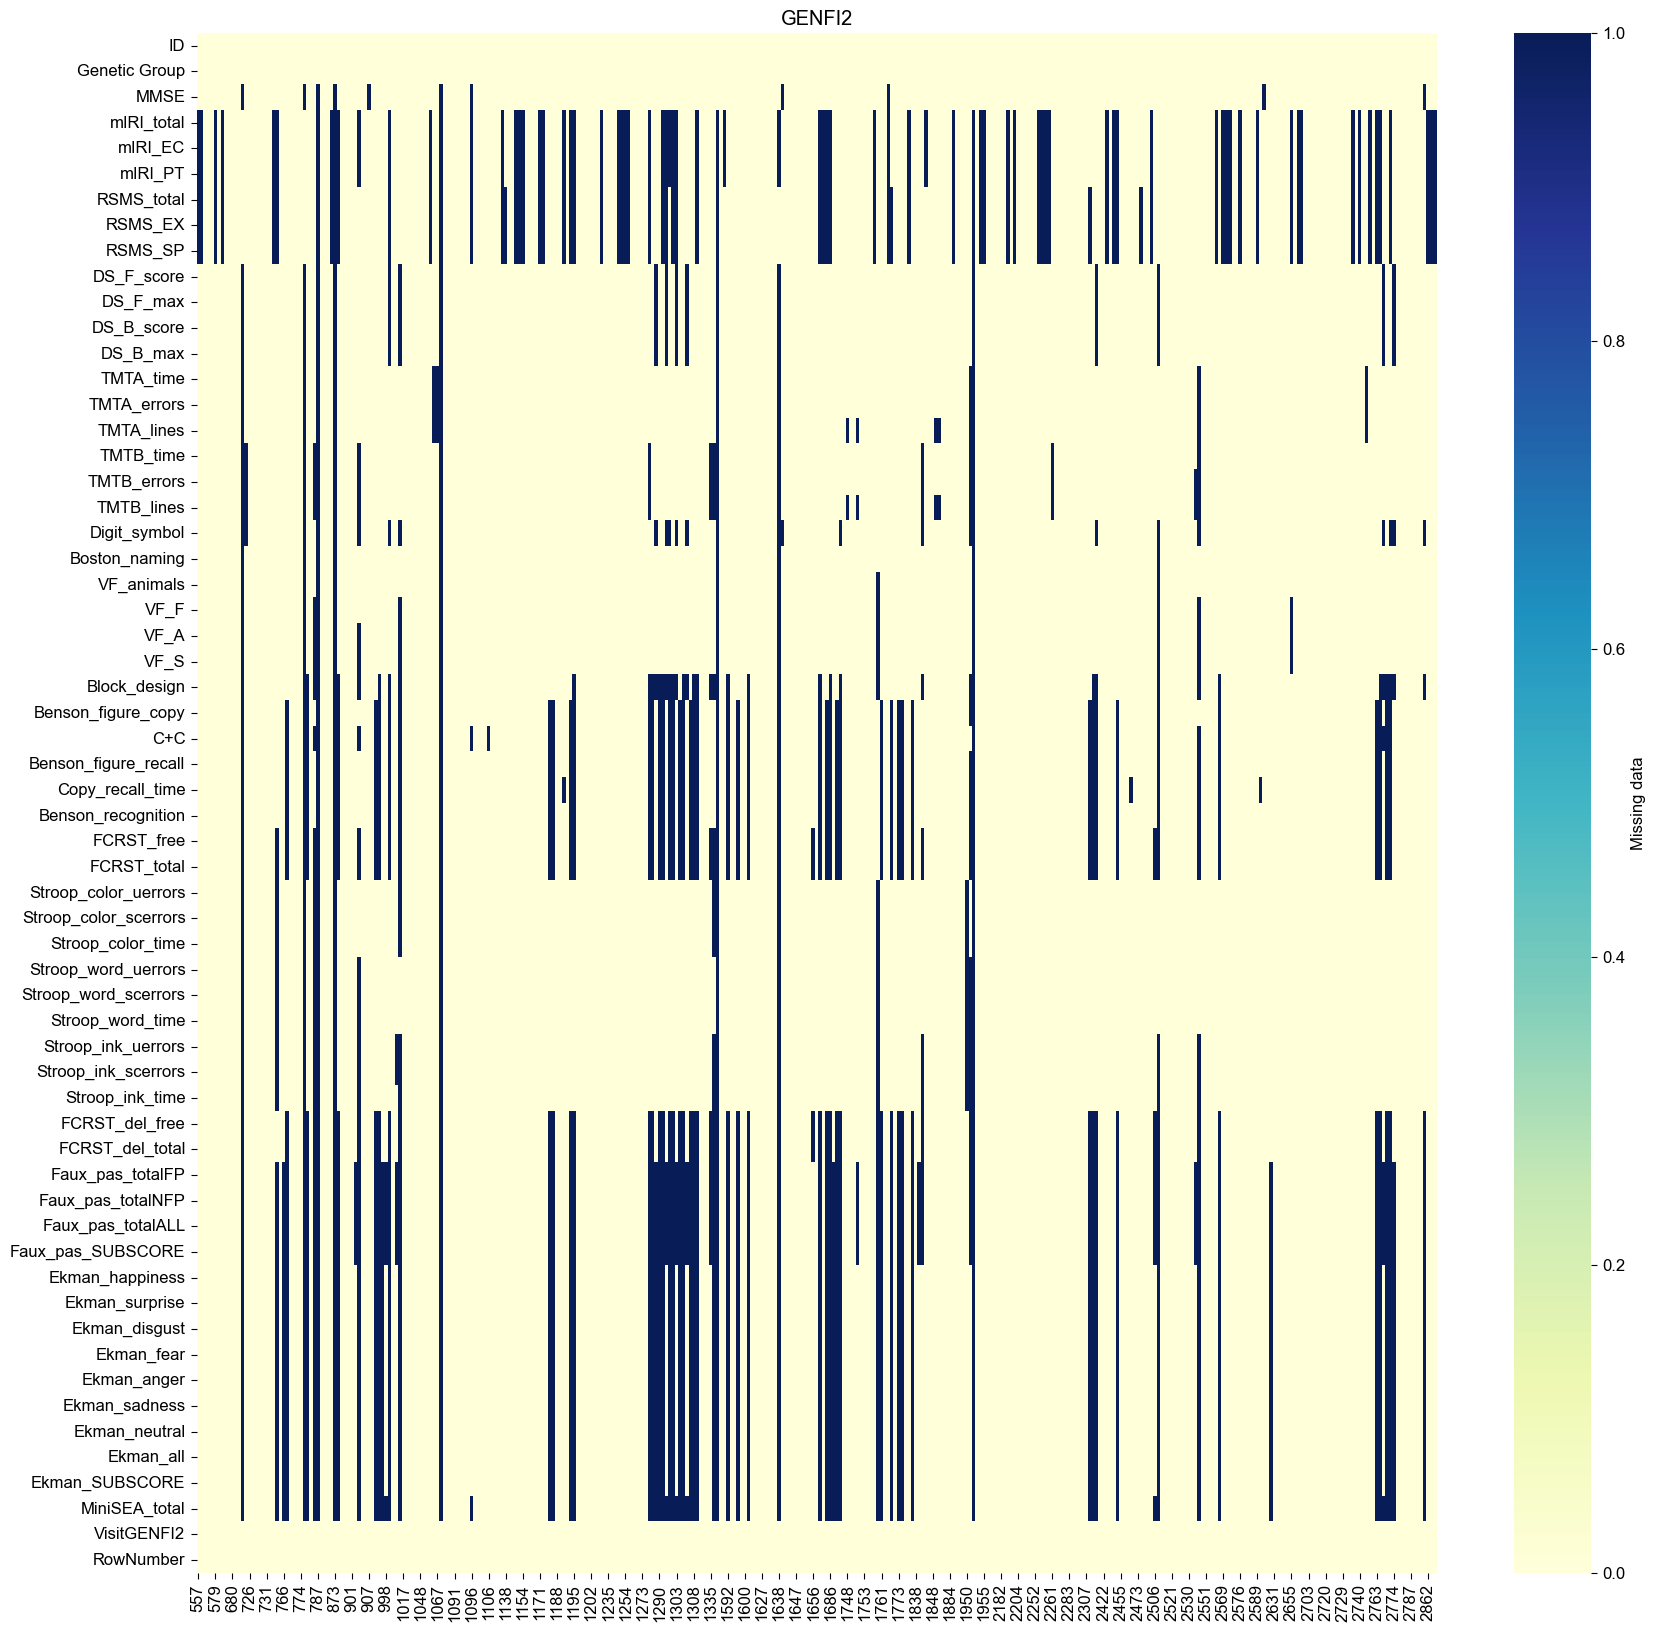

In [101]:
# Visualise how much missing data there are for the neuropsych variables
sns.heatmap(genfi_behav_dropkey_GENFI2_3tp_copy_rm_tokeep_neuropsych.isna().transpose(),
           cmap="YlGnBu",
           cbar_kws={"label": "Missing data"}).set(title="GENFI2")

Now I examine the same for the clinical variables to see whether we can keep some of them in.

In [102]:
# make a copy of the df
genfi_behav_dropkey_GENFI2_3tp_copy_rm_tokeep_clinical = genfi_behav_dropkey_GENFI2_3tp_copy_rm.copy()

# make list of cols to keep using the cols object above
ColstoKeep_clinical = ['ID',
 'Affected.1',
 'Disinhibition',
 'Apathy',
 'Empathy',
 'OCD',
 'Appetite',
 'Affected.2',
 'Vis_hal',
 'Aud_hal',
 'Tac_hal',
 'Delusions',
 'Depression',
 'Anxiety',
 'Affected.3',
 'Artic',
 'Fluency',
 'Grammar',
 'Retrieval',
 'Repetition',
 'Sent_comp',
 'Word_comp',
 'Dyslexia',
 'Dysgraphia',
 'Func_comm',
 'Affected.4',
 'Memory',
 'Visuospatial',
 'Judg_prob_solv',
 'Attention',
 'Affected.5',
 'Dysarthria',
 'Dysphagia',
 'Tremor',
 'Slowness',
 'Weakness',
 'Gait',
 'Falls',
 'Seizures',
 'Stroke',
 'TBI',
 'Hypertension',
 'Hyperchol',
 'Diabetes',
 'Supranuclear',
 'Bulbar',
 'Pseudobulbar',
 'Abnormal_gait',
 'Type',
 'Severity',
 'Everyday_Skills',
 'Self_Care',
 'Abnormal_Behaviour',
 'Mood',
 'Beliefs',
 'Eating',
 'Sleep',
 'Stereotypic_Behaviour',
 'Motivation',
 'CBI_Total',
 'FRS_%',
 'ALSFRS_total',
 'FTLD-CDR-SOB',
 'FTLD-CDR-GLOBAL',
 'CDR-SOB',
 'GENFI-CDR-SOB',
 'GENFI-CDR-GLOBAL',
 'BEHAV-SOB',
 'PASS-SOB',
 'VisitGENFI2',
 "RowNumber"]

# keep only the above cols
genfi_behav_dropkey_GENFI2_3tp_copy_rm_tokeep_clinical = genfi_behav_dropkey_GENFI2_3tp_copy_rm_tokeep_clinical.filter(ColstoKeep_clinical)

# count how many NaNs there are in the full data frame as a percentage of the number of rows and columns 
genfi_behav_dropkey_GENFI2_3tp_copy_rm_tokeep_clinical.isna().sum().sum() / (genfi_behav_dropkey_GENFI2_3tp_copy_rm_tokeep_clinical.shape[0] * genfi_behav_dropkey_GENFI2_3tp_copy_rm_tokeep_clinical.shape[1])
# 40%ish missing data! Oh wow.

0.3809800954487254

[Text(0.5, 1.0, 'GENFI2')]

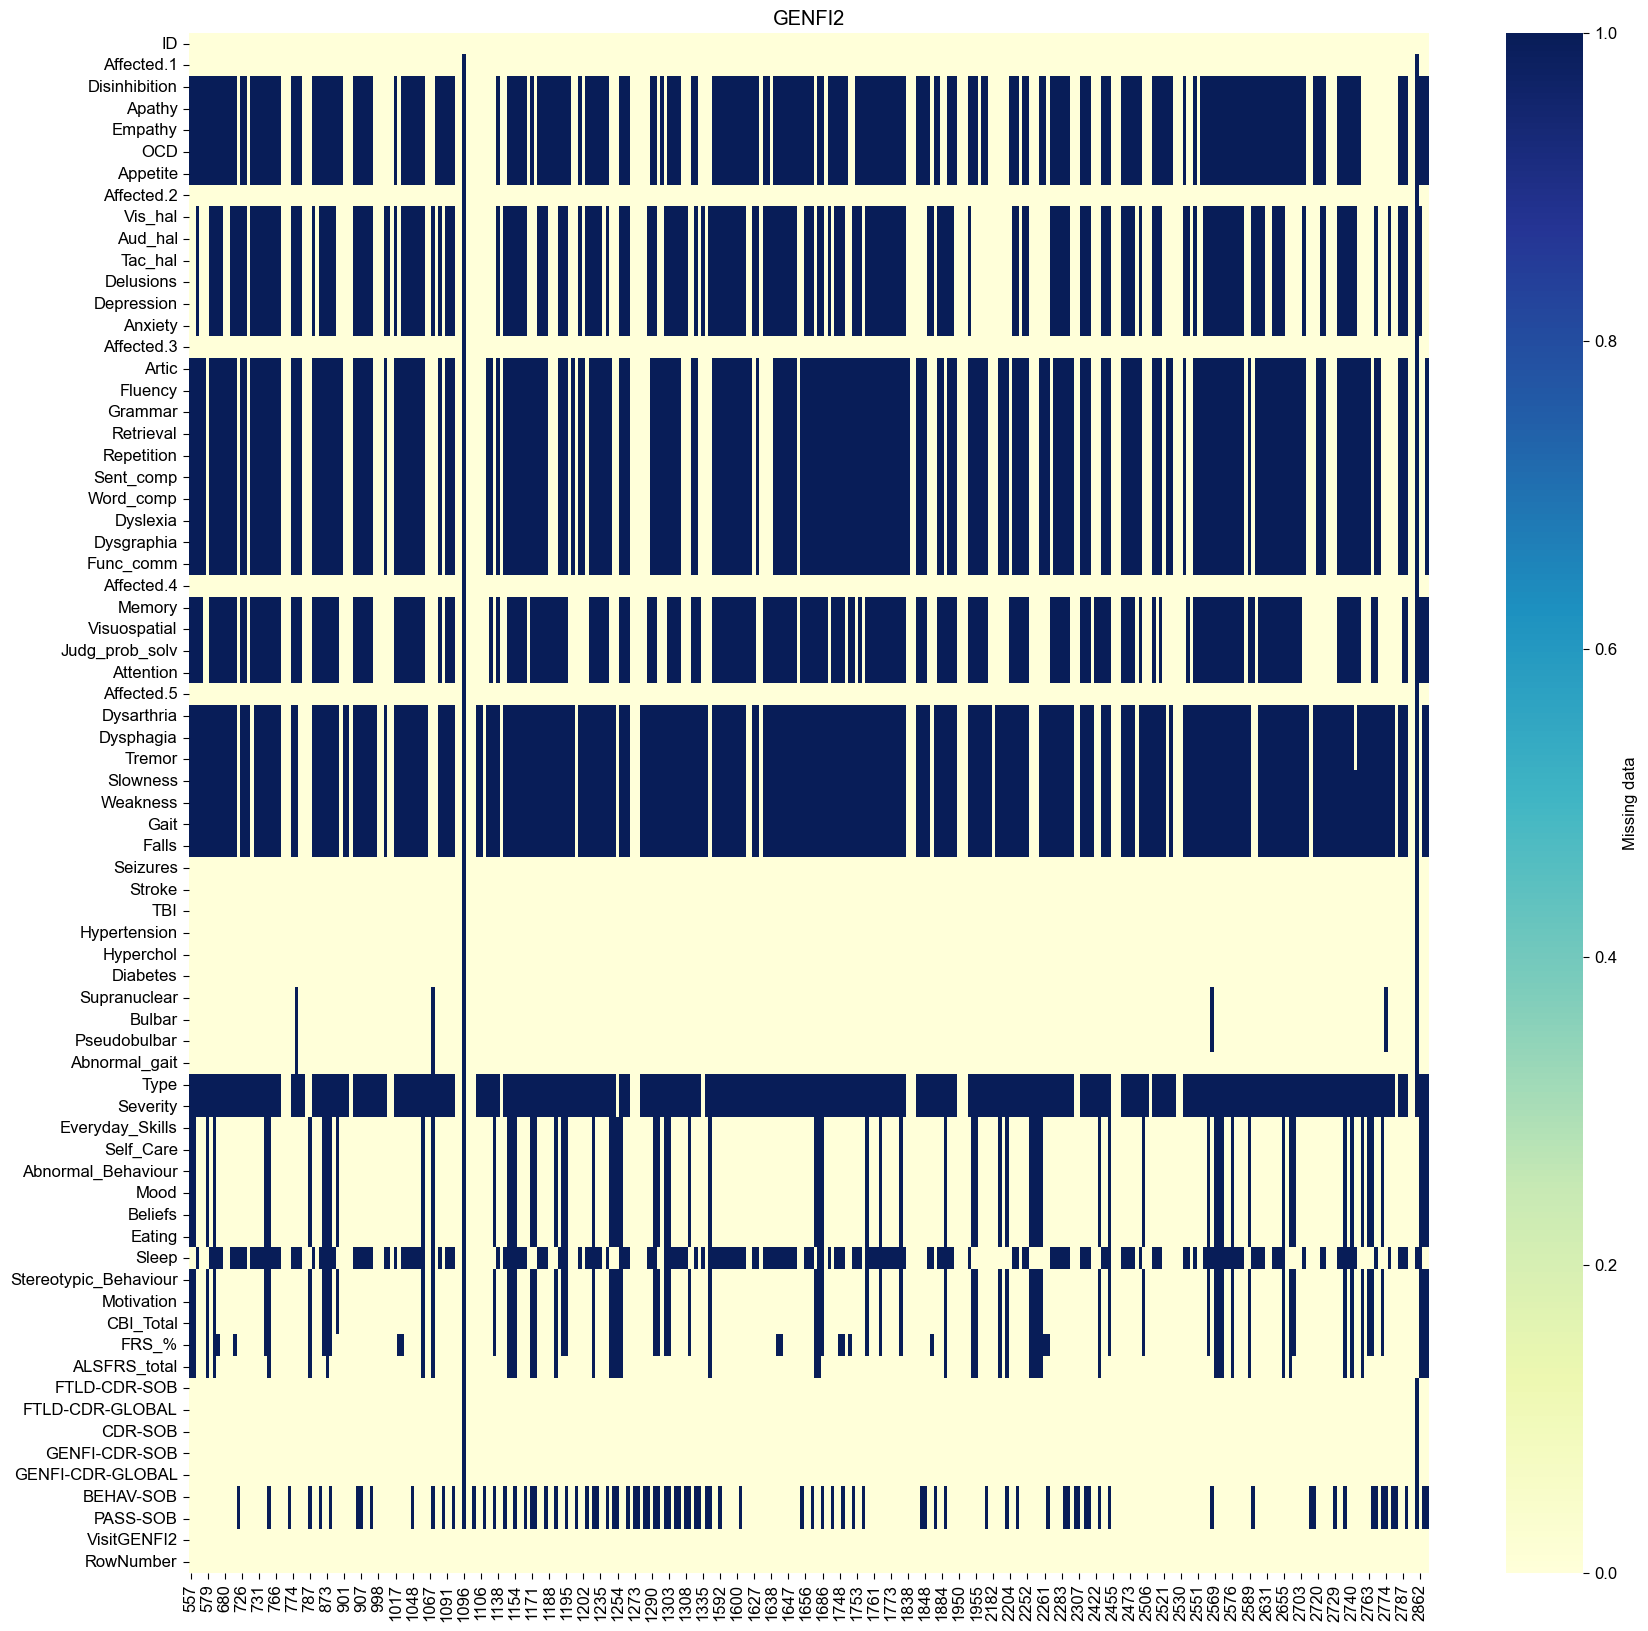

In [103]:
# Visualise how much missing data there are for the neuropsych variables
sns.heatmap(genfi_behav_dropkey_GENFI2_3tp_copy_rm_tokeep_clinical.isna().transpose(),
           cmap="YlGnBu",
           cbar_kws={"label": "Missing data"}).set(title="GENFI2")

So it looks like there are a whole bunch of variables that actually have data that we could use later. Even measures such as the "Affected" cols can be used to project data later. So I'll keep all these variables. I'll combine these measures with neuropsych from above. Then for my analyses, I'll retain only neuropsych and project clinical variables in.

### Missing data handling in GENFI2 carrier neuropsychology data

Now that I have decided which neuropsychology variables to keep, I need to impute the missing neuropsychology data. I will use MICE (Multiple Imputations via Chained Equations) where I can set a few predictors (e.g., Age, Education, Sex, GENFI CDR SoB, Genetic group and Visit time point) to estiamte their missing data. In R, I would have used the dedicated MICE package but in Python, it looks like there is a miceforest package that uses light gradient boosting to impute. Prior to trying that out, I will create a new df with all the neuropsych variables + the predictors that I have outlined above. I will retain RowNumber as that variable has no missing data so it won't be imputed, but that variable is important for me to left-join in the clinical data later. 

In [104]:
# create a copy of the df 
genfi_GENFI2_3tp_neuropsych_final_1 = genfi_behav_dropkey_GENFI2_3tp_copy_rm.copy()

# make a list of the neuropsych columns including the predictors
# note that I have removed ID and will use row number to left_join with the above dataset later
FinalColsToKeep_neuropsych = ['Genetic Group',
 'VisitGENFI2',
 'RowNumber',
 'Gender',
 "Education",
 'Age at visit',
 'FTLD-CDR-SOB',
 'MMSE',
 'mIRI_total',
 'mIRI_EC',
 'mIRI_PT',
 'RSMS_total',
 'RSMS_EX',
 'RSMS_SP',
 'DS_F_score',
 'DS_F_max',
 'DS_B_score',
 'DS_B_max',
 'TMTA_time',
 'TMTA_errors',
 'TMTA_lines',
 'TMTB_time',
 'TMTB_errors',
 'TMTB_lines',
 'Digit_symbol',
 'Boston_naming',
 'VF_animals',
 'VF_F',
 'VF_A',
 'VF_S',
 'Block_design',
 'Benson_figure_copy',
 'C+C',
 'Benson_figure_recall',
 'Copy_recall_time',
 'Benson_recognition',
 'FCRST_free',
 'FCRST_total',
 'Stroop_color_uerrors',
 'Stroop_color_scerrors',
 'Stroop_color_time',
 'Stroop_word_uerrors',
 'Stroop_word_scerrors',
 'Stroop_word_time',
 'Stroop_ink_uerrors',
 'Stroop_ink_scerrors',
 'Stroop_ink_time',
 'FCRST_del_free',
 'FCRST_del_total',
 'Faux_pas_totalFP',
 'Faux_pas_totalNFP',
 'Faux_pas_totalALL',
 'Faux_pas_SUBSCORE',
 'Ekman_happiness',
 'Ekman_surprise',
 'Ekman_disgust',
 'Ekman_fear',
 'Ekman_anger',
 'Ekman_sadness',
 'Ekman_neutral',
 'Ekman_all',
 'Ekman_SUBSCORE',
 'MiniSEA_total']

# keep only the above cols
genfi_GENFI2_3tp_neuropsych_final = genfi_GENFI2_3tp_neuropsych_final_1[FinalColsToKeep_neuropsych]

# have I retained 3 time point data for all? Check if df is divisible by 3
len(genfi_GENFI2_3tp_neuropsych_final)/3
# perfect

121.0

Before imputing, I now check the range of the data to see if any outliers exist. For example, sometimes values are coded as 999 or something like that. I don't want these values to be used to impute.

In [105]:
if 2 in genfi_GENFI2_3tp_neuropsych_final.values:
    print ("Element exists")

Element exists


I now replace 999s with NaN, plot the data and see if any anomalies exist.

<Axes: >

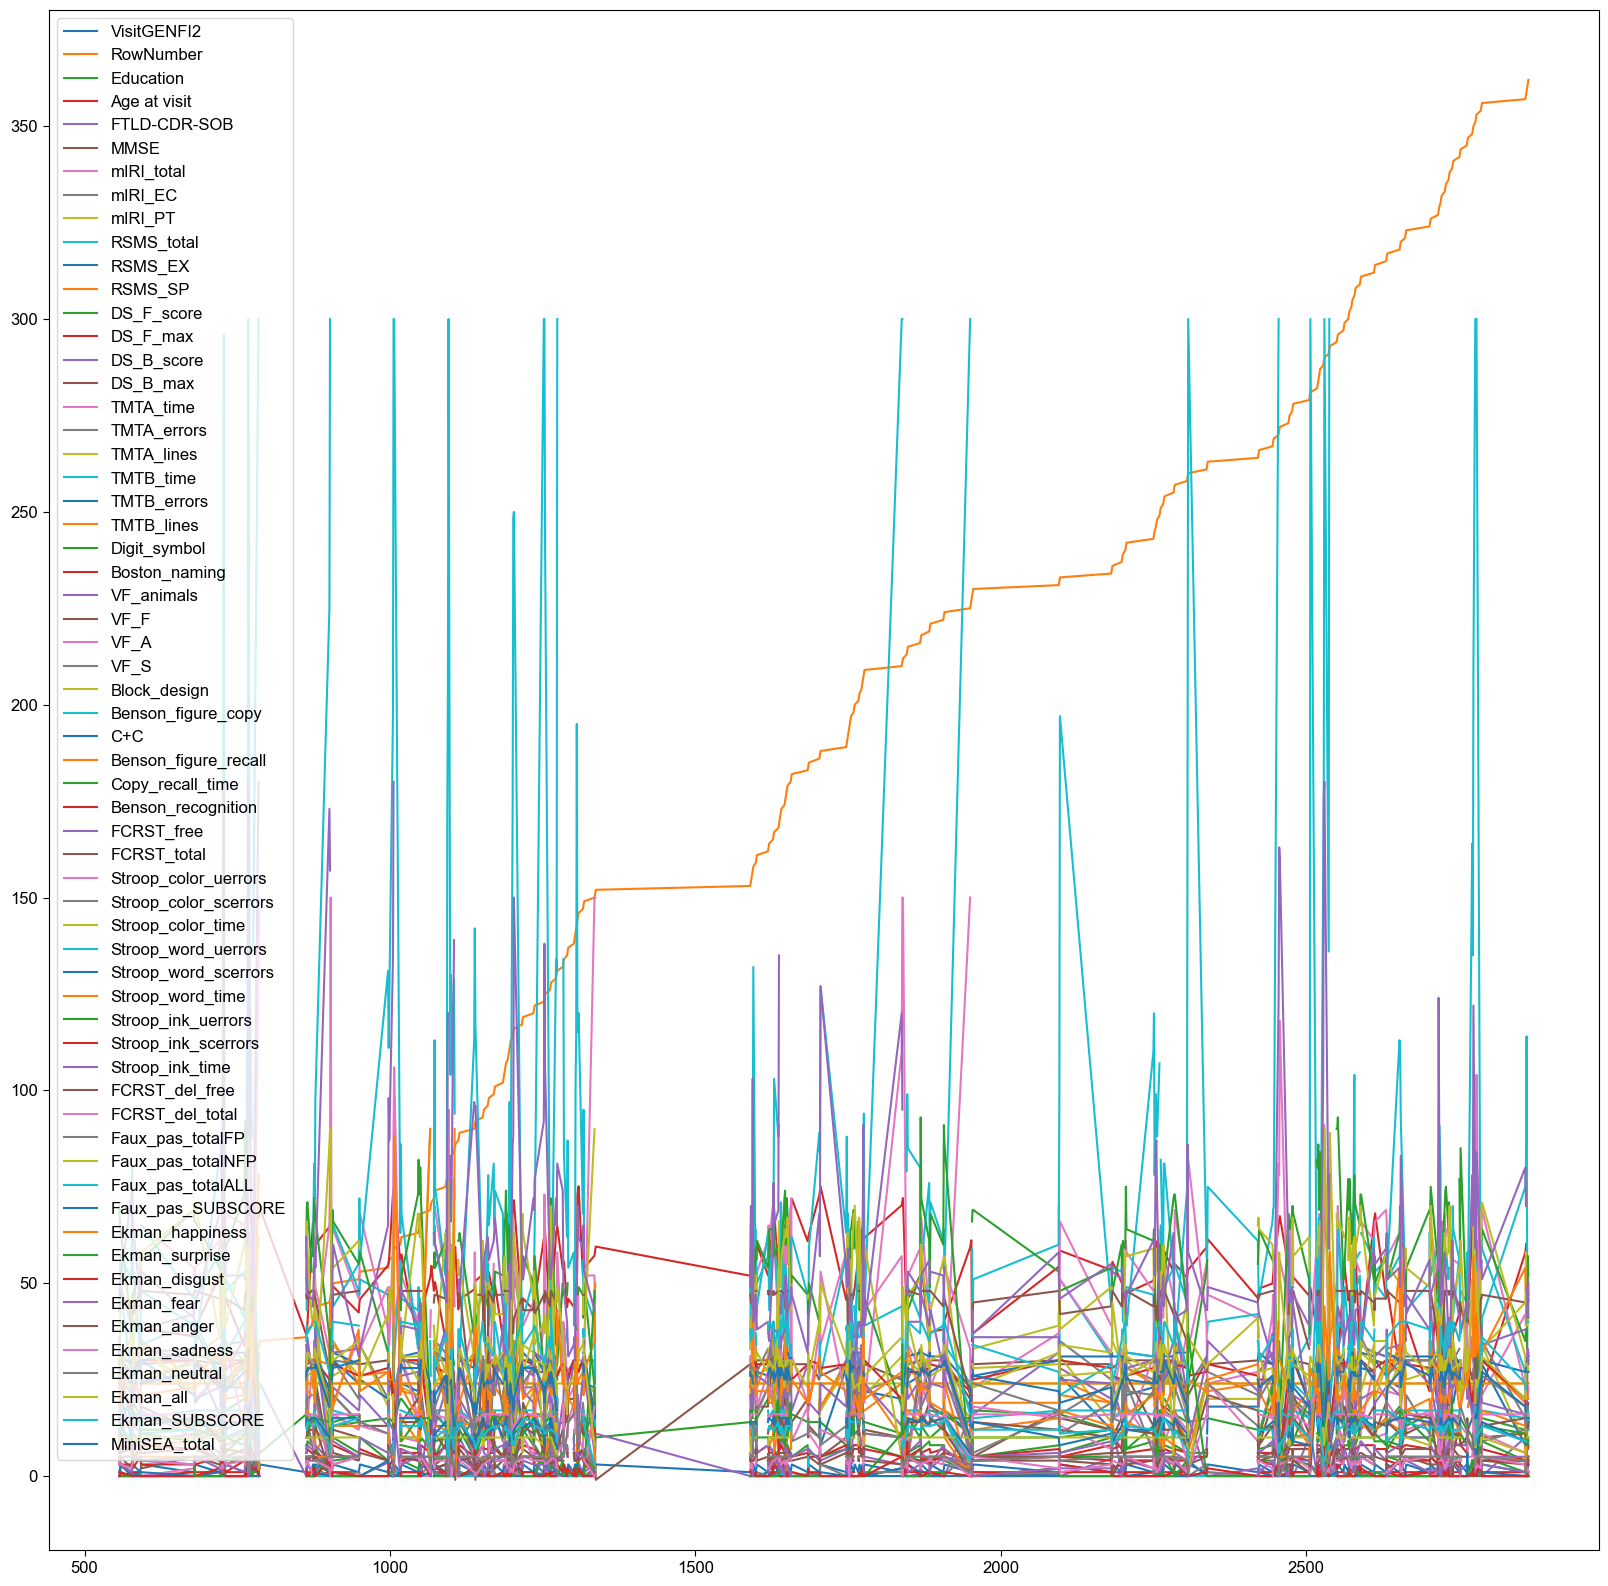

In [106]:
genfi_GENFI2_3tp_neuropsych_final_2 = genfi_GENFI2_3tp_neuropsych_final.replace(999, np.nan).copy();

# does the missing data # increase because of this substitution?
genfi_GENFI2_3tp_neuropsych_final_2.isna().sum().sum() / (genfi_GENFI2_3tp_neuropsych_final_2.shape[0] * genfi_GENFI2_3tp_neuropsych_final_2.shape[1])
# no real change. Went from 10.2 to 10.4%

# plot the data once and see what the distribution looks like
genfi_GENFI2_3tp_neuropsych_final_2.plot()

Now I use miceforest to impute the missing values in this dataset. I set the predictors using the variable_schema list. Unfortunately, the way miceforest works is that I have to set the variable_schema dictionary for every single variable that I want to impute. Here, I set the predictors to Group, Visit number, Gender, Education, Age at visit, and CDR-FTLD-SoB.

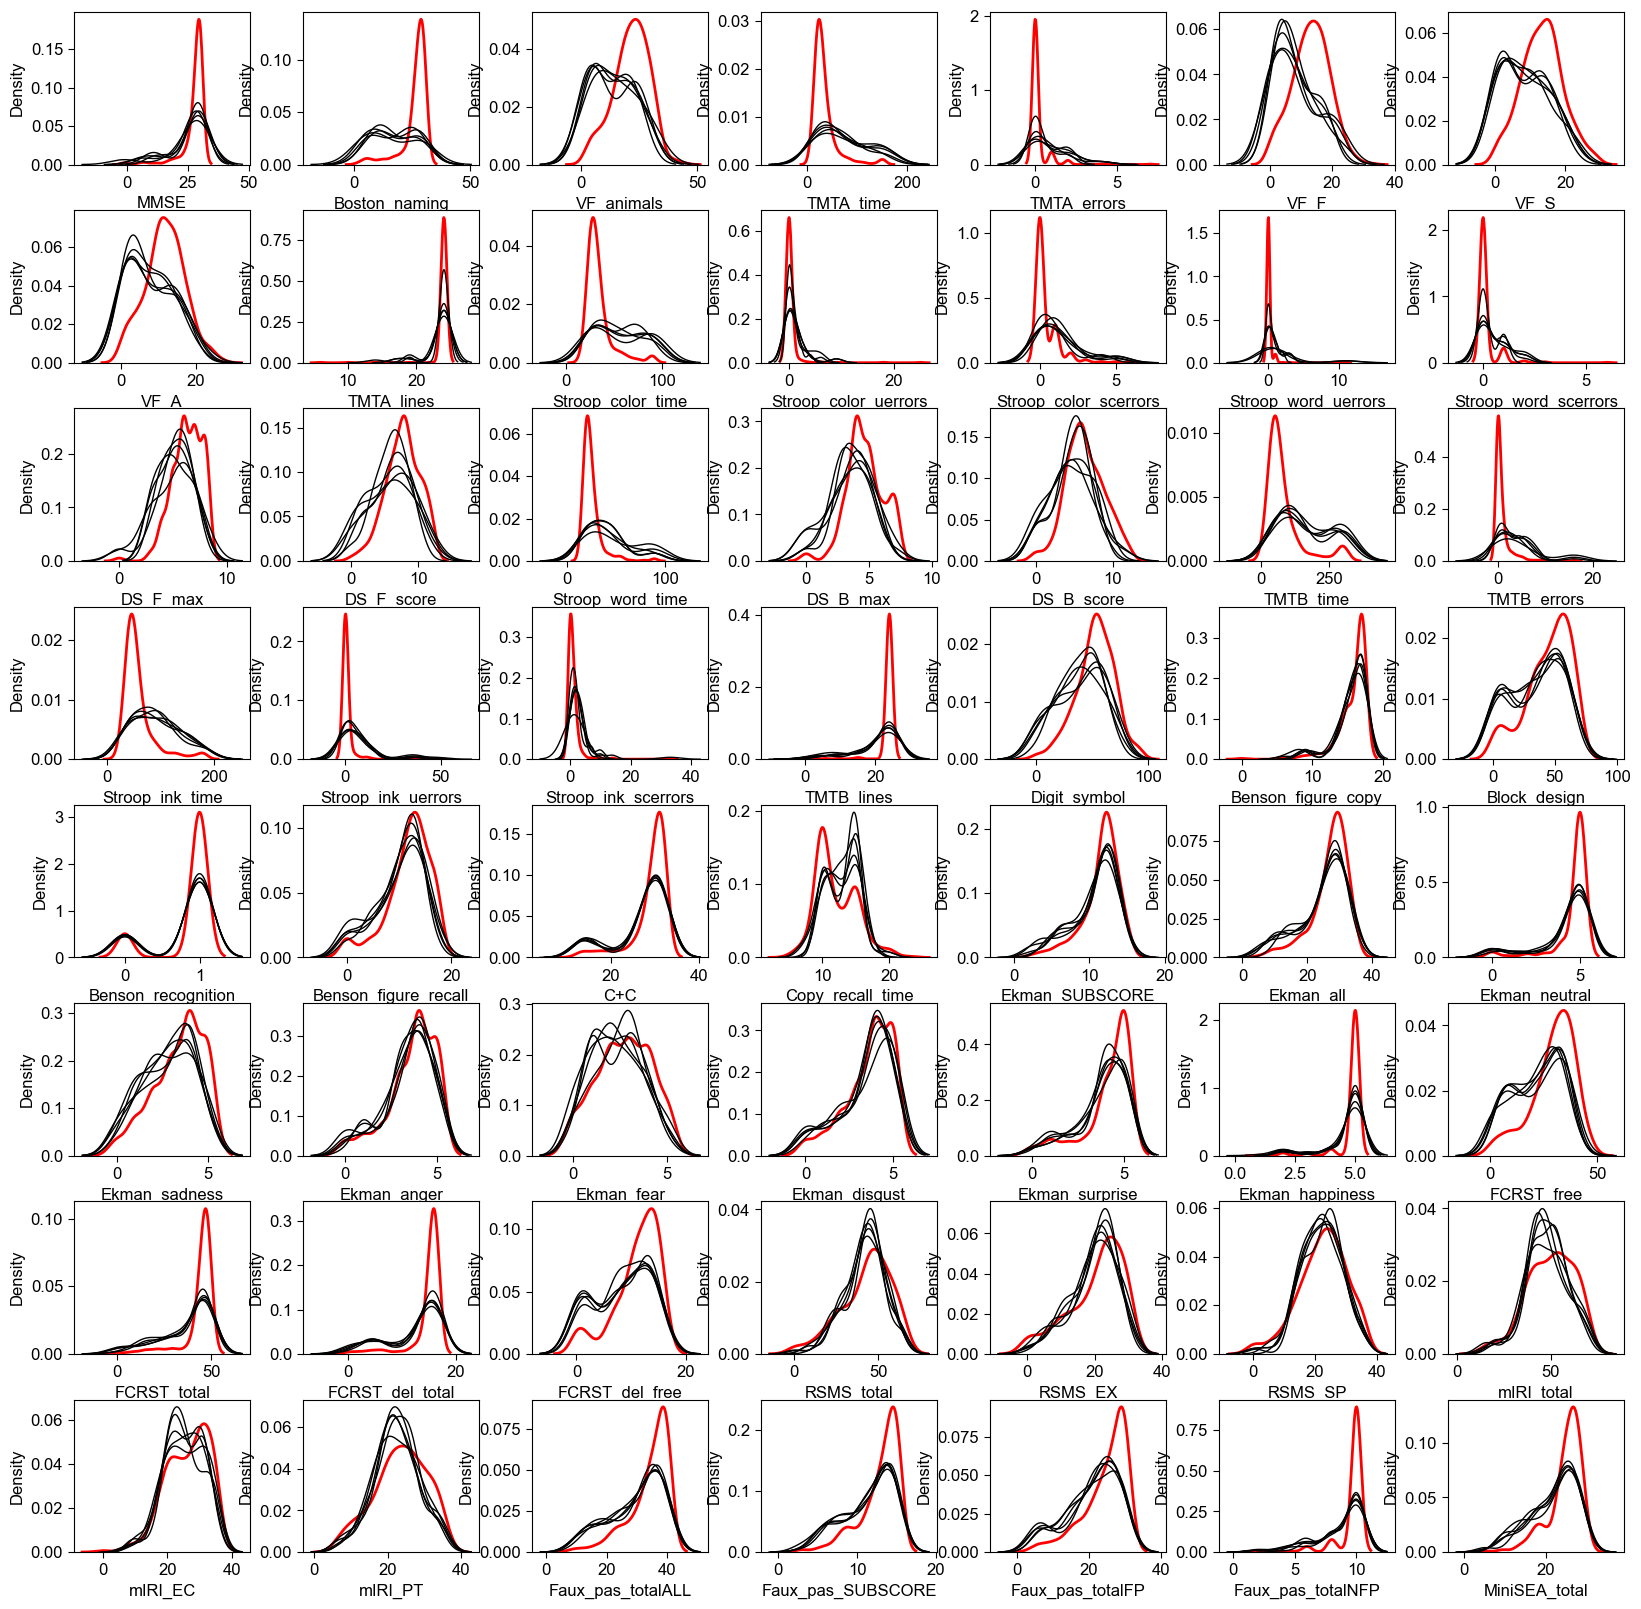

In [107]:
# create a copy of the df to impute
genfi_GENFI2_3tp_neuropsych_final_toimpute = genfi_GENFI2_3tp_neuropsych_final_2.copy()

# set predictors from objects to integer or categorical variables
genfi_GENFI2_3tp_neuropsych_final_toimpute["VisitGENFI2"] = genfi_GENFI2_3tp_neuropsych_final_toimpute["VisitGENFI2"].astype(float)
genfi_GENFI2_3tp_neuropsych_final_toimpute["Genetic Group"] = genfi_GENFI2_3tp_neuropsych_final_toimpute["Genetic Group"].astype("category")
genfi_GENFI2_3tp_neuropsych_final_toimpute["Gender"] = genfi_GENFI2_3tp_neuropsych_final_toimpute["Gender"].astype("category")
genfi_GENFI2_3tp_neuropsych_final_toimpute["Education"] = genfi_GENFI2_3tp_neuropsych_final_toimpute["Education"].astype(float)
genfi_GENFI2_3tp_neuropsych_final_toimpute["Age at visit"] = genfi_GENFI2_3tp_neuropsych_final_toimpute["Age at visit"].astype(float)
genfi_GENFI2_3tp_neuropsych_final_toimpute["FTLD-CDR-SOB"] = genfi_GENFI2_3tp_neuropsych_final_toimpute["FTLD-CDR-SOB"].astype(float)

# set predictor dictionary
var_sch = {
    "MMSE": ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
    'mIRI_total': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'mIRI_EC': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'mIRI_PT': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'RSMS_total': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'RSMS_EX': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'RSMS_SP': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'DS_F_score': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'DS_F_max': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'DS_B_score': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'DS_B_max': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'TMTA_time': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'TMTA_errors': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'TMTA_lines': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'TMTB_time': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'TMTB_errors': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'TMTB_lines': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Digit_symbol': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Boston_naming': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'VF_animals': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'VF_F': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'VF_A': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'VF_S': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Block_design': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Benson_figure_copy': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'C+C': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Benson_figure_recall': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Copy_recall_time': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Benson_recognition': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'FCRST_free': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'FCRST_total': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Stroop_color_uerrors': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Stroop_color_scerrors': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Stroop_color_time': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Stroop_word_uerrors': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Stroop_word_scerrors': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Stroop_word_time': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Stroop_ink_uerrors': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Stroop_ink_scerrors': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Stroop_ink_time': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'FCRST_del_free': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'FCRST_del_total': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Faux_pas_totalFP': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Faux_pas_totalNFP': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Faux_pas_totalALL': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Faux_pas_SUBSCORE': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Ekman_happiness': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Ekman_surprise': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Ekman_disgust': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Ekman_fear': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Ekman_anger': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Ekman_sadness': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Ekman_neutral': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Ekman_all': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'Ekman_SUBSCORE': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB'],
 'MiniSEA_total': ["Genetic Group", 'VisitGENFI2', 'Gender', "Education", 'Age at visit', 'FTLD-CDR-SOB']
}

# create a MICE kernel with 5 datasets to be produced via imputation
kernel = mf.ImputationKernel(
    genfi_GENFI2_3tp_neuropsych_final_toimpute,
    datasets=5,
    variable_schema=var_sch,
    mean_match_scheme=mean_match_shap, # use the highest quality of imputation using Shapley value, see help(mean_match_shap)
    random_state=1991) # set seed for reproducibility

# run the MICE algorithm for 5 iterations on the kernal
kernel.mice(5, n_jobs=5)

# check the imputed values for each variable. Note that Red is original data and each black line is the imputed values from each dataset
kernel.plot_imputed_distributions(wspace=.3, hspace=.3)
# looks good for most vars. Doesn't look like MICE has imputed in a weird manner.

I now run a few diagnostic plots to see whether the imputation worked.

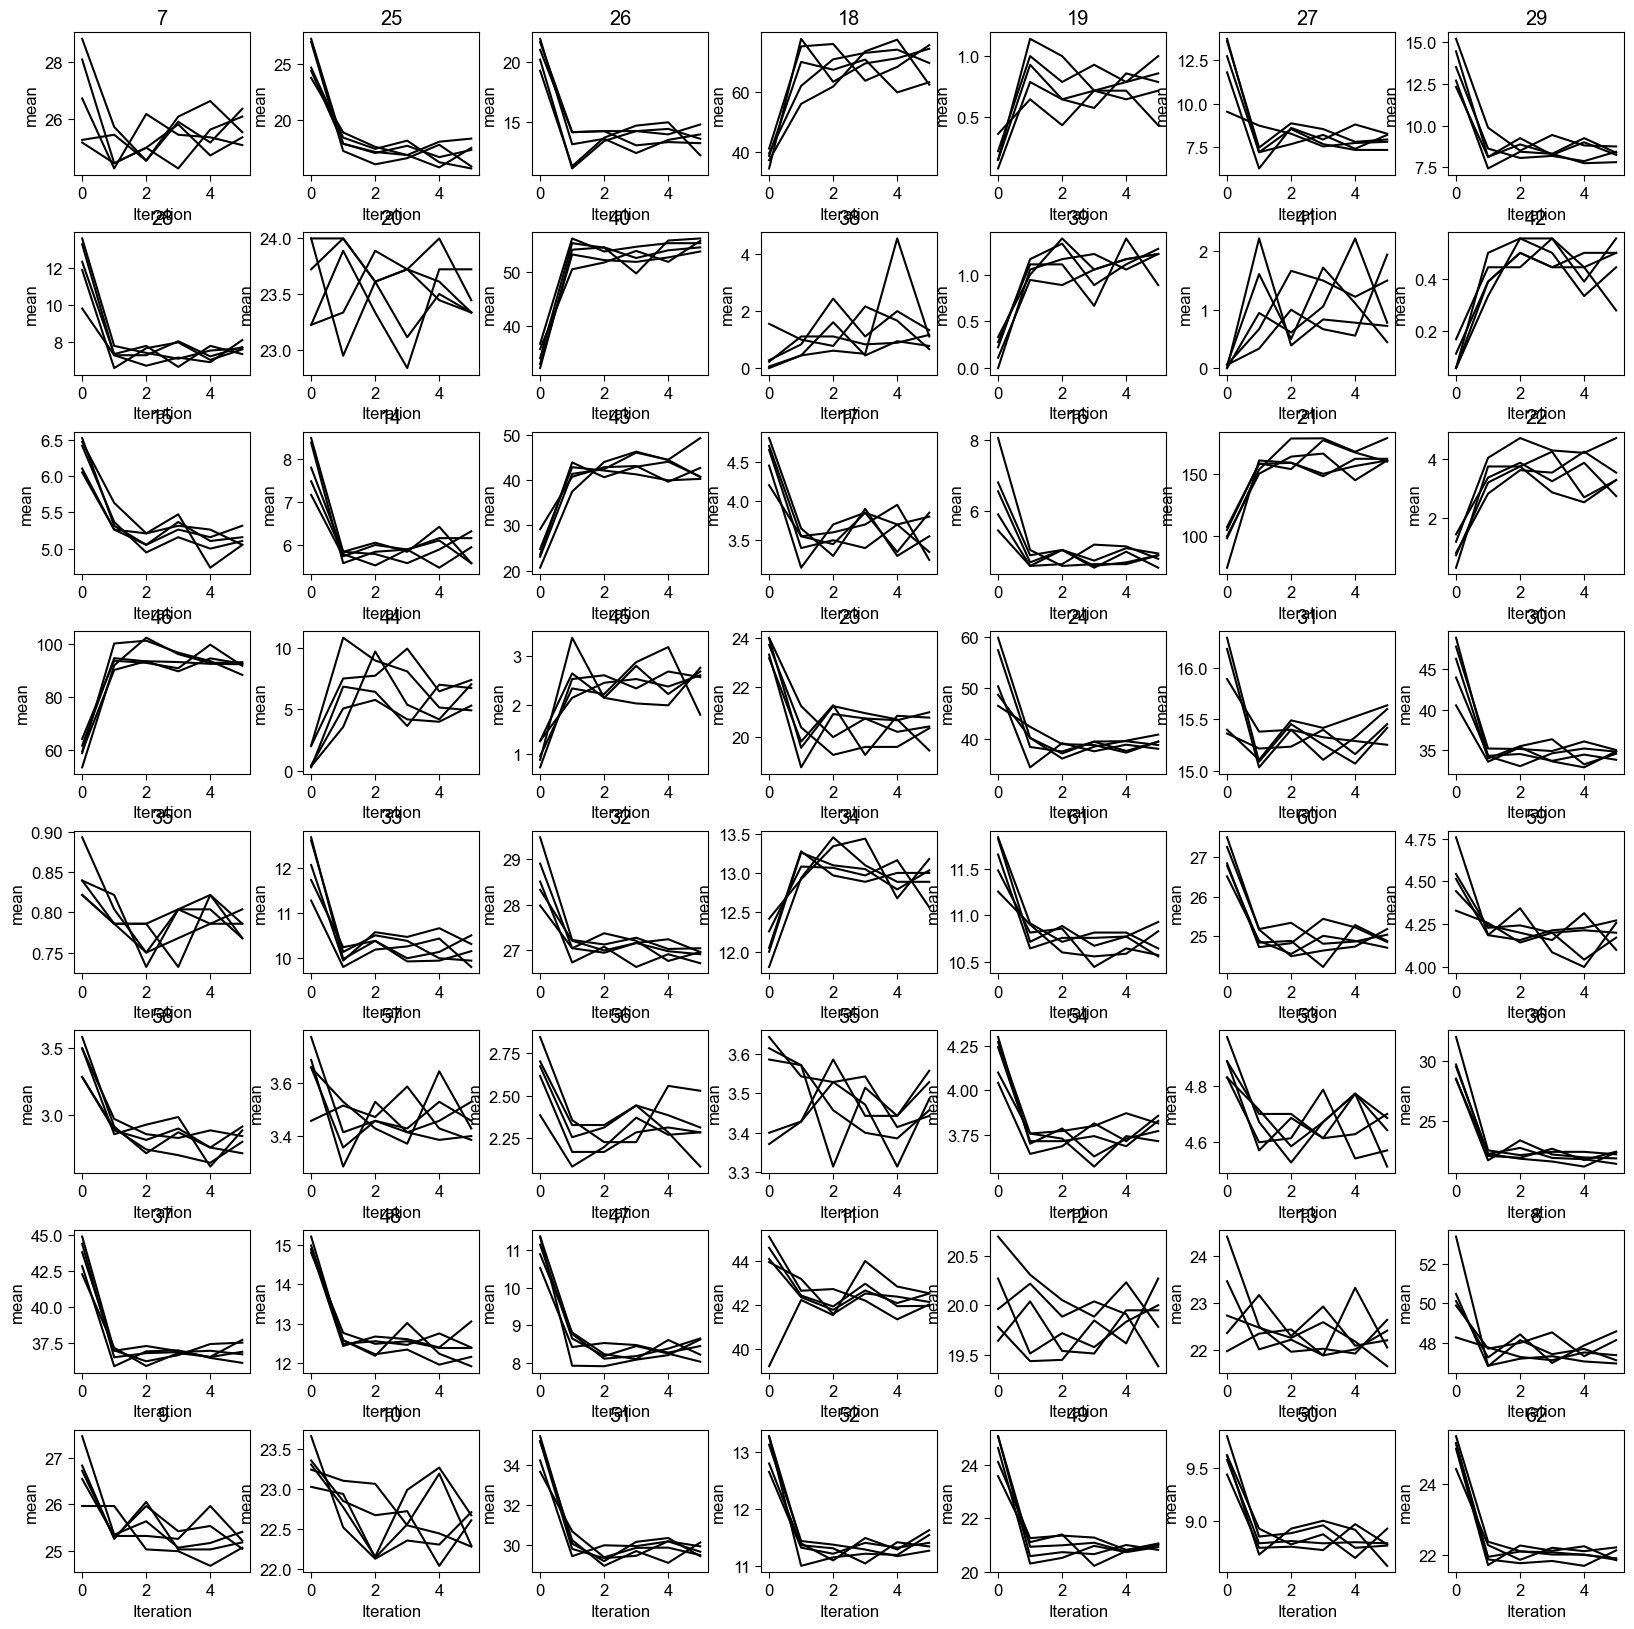

In [108]:
# examine what the convergence of each iteration for imputation looks like
kernel.plot_mean_convergence(wspace=0.3, hspace=0.4)
# from the miceforest tutorial, "If our data is not missing completely at random...
# we may see that it takes a few iterations for our models to get the distribution of imputations right...
# Our data is missing completely at random, so we don’t see any convergence occurring here."

# this above seems to apply to most of the variables in this dataset

Axes(0.125,0.11;0.62x0.77)


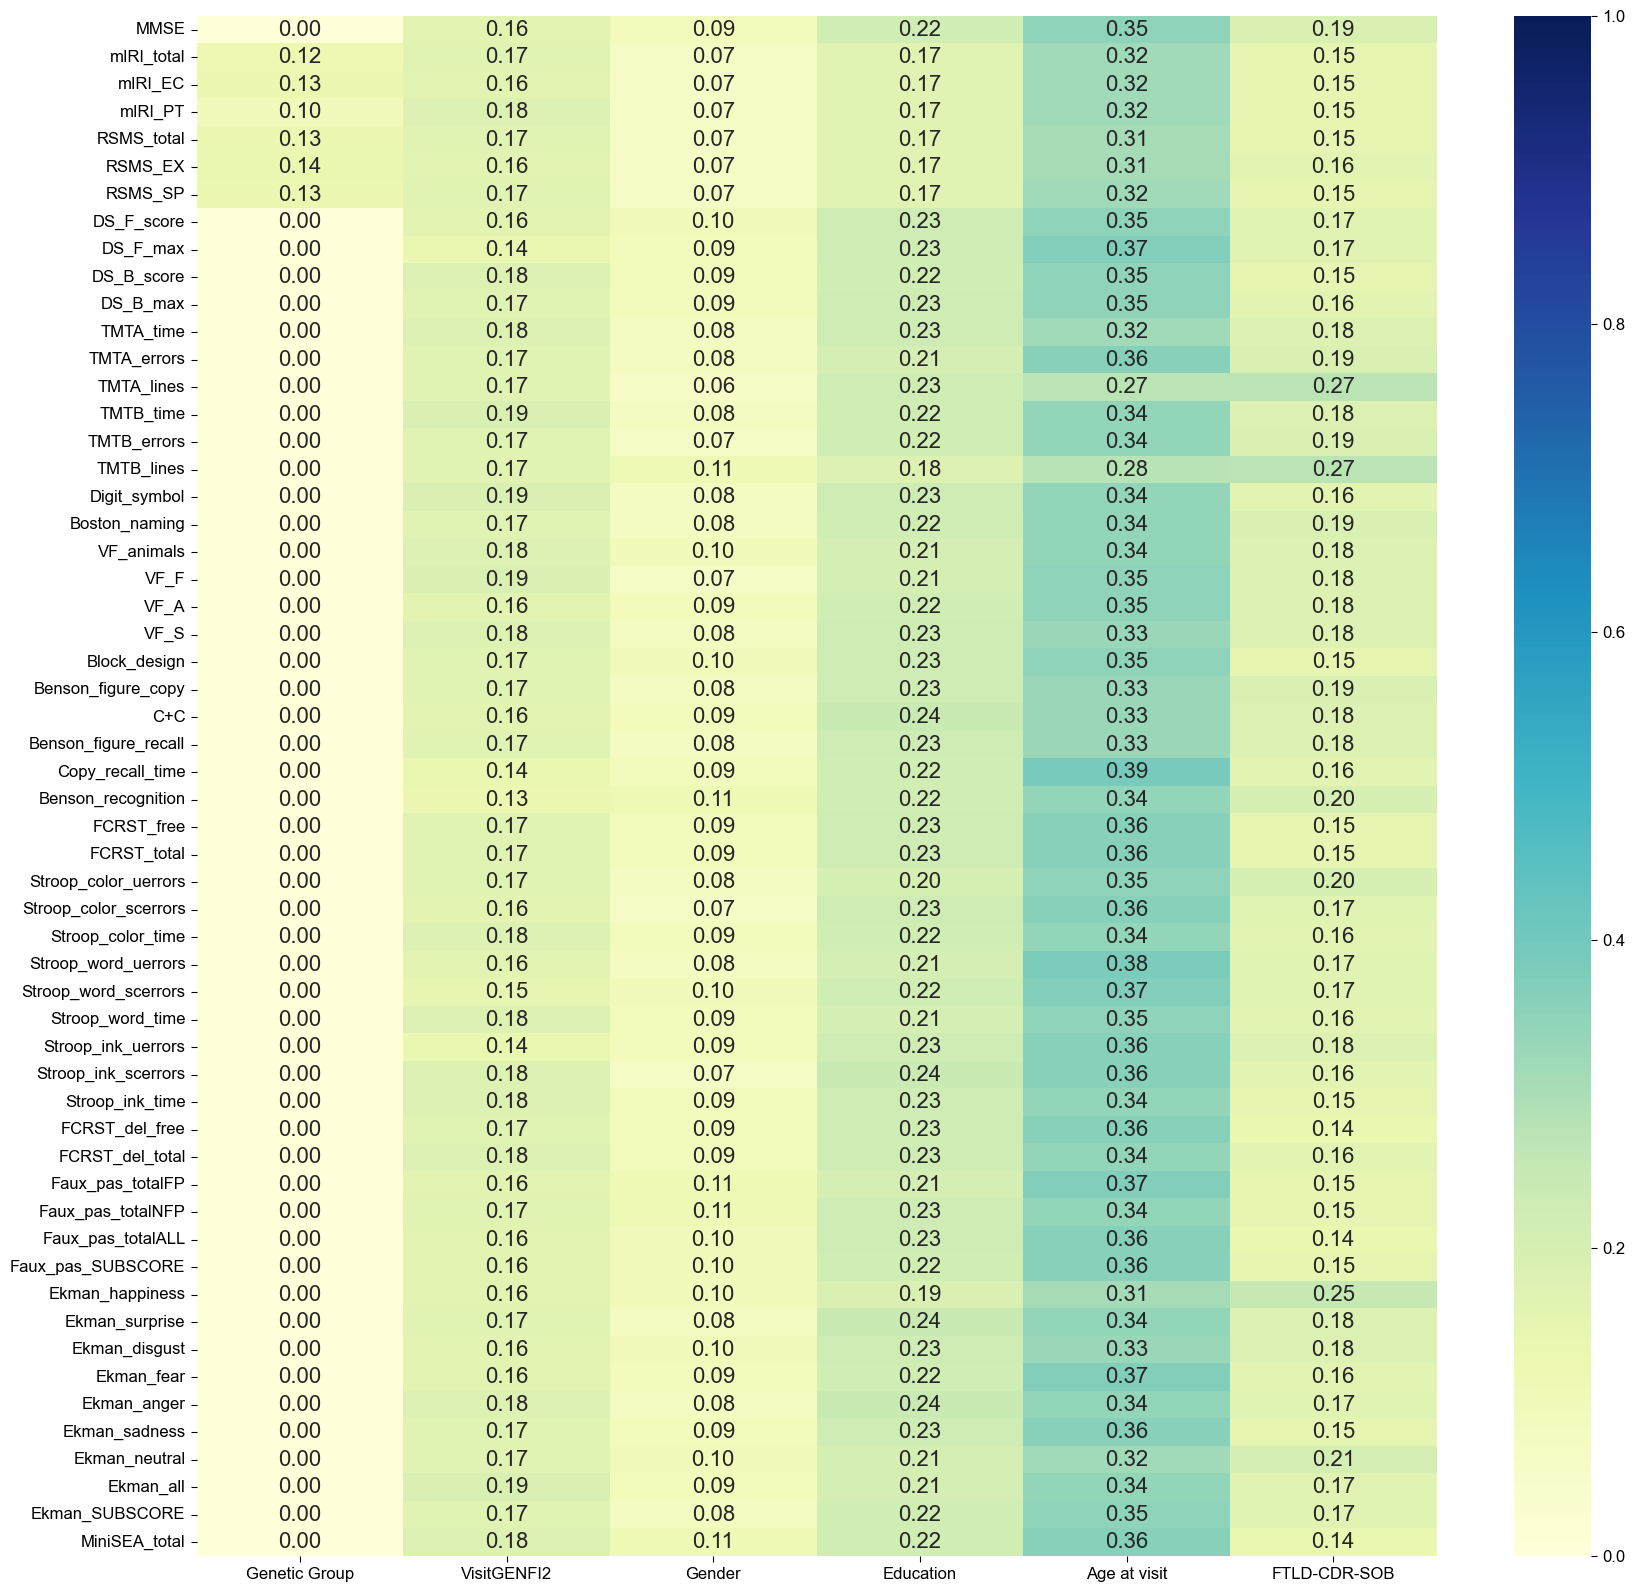

In [109]:
# finally, examine the importance of each of our predictors foc imputation
kernel.plot_feature_importance(dataset=0, annot=True,cmap="YlGnBu",vmin=0, vmax=1)
# looks like age of onset is the most important predictor of missing data for most cases

In [110]:
# complete the dataset with the imputed values
genfi_GENFI2_3tp_neuropsych_final_imputed = kernel.complete_data(dataset=0)
genfi_GENFI2_3tp_neuropsych_final_imputed.isnull().sum().head(50)
# no missing data in the neuropsych vars of interest 4 in the FTLD CDR SOB but thats ok.

Genetic Group            0
VisitGENFI2              0
RowNumber                0
Gender                   0
Education                0
Age at visit             0
FTLD-CDR-SOB             2
MMSE                     0
mIRI_total               0
mIRI_EC                  0
mIRI_PT                  0
RSMS_total               0
RSMS_EX                  0
RSMS_SP                  0
DS_F_score               0
DS_F_max                 0
DS_B_score               0
DS_B_max                 0
TMTA_time                0
TMTA_errors              0
TMTA_lines               0
TMTB_time                0
TMTB_errors              0
TMTB_lines               0
Digit_symbol             0
Boston_naming            0
VF_animals               0
VF_F                     0
VF_A                     0
VF_S                     0
Block_design             0
Benson_figure_copy       0
C+C                      0
Benson_figure_recall     0
Copy_recall_time         0
Benson_recognition       0
FCRST_free               0
F

### Prepare data for PCA and other analyses

Now that all missing data have been removed, I will prepare it for PCA. First, I will scale and order the data, converting all values to percentages. Then I will remove all the ID and predictor values. I will then enter it into a PCA, add in a row identifier, and finally, left join in the clinical data. Note that for variables where there is no maximum value (e.g., Trails, verbal fluency), the local maximum/minimum will be used as the cap. The maximum possible scores for all variables are coded in the raw neuropsychology excel sheet.

Now there are a series of vars which don't have a designated max score. Tests like the TMT B-A, on the other hand, followed an inverse scoring pattern (with higher scores indicative of poorer performance) with no maximum attainable scores; a two-step approach to standardization is adopted. First, these are converted into percentages using the ‘local maximum’ score (e.g.., highest TMT B-A score, indicative of poorest performance) using the formula: (raw score / local maximum) * 100. This score was subsequently subtracted from 100 to derive an index of performance percentage. I will employ this method this for the following vars: 
'TMTA_time',
'TMTA_errors', 
    'TMTB_time',
    'TMTB_errors',
    'Copy_recall_time',
    'Stroop_color_uerrors', 
    'Stroop_color_scerrors', 
    'Stroop_color_time',
    'Stroop_word_uerrors', 
    'Stroop_word_scerrors', 
    'Stroop_word_time',
    'Stroop_ink_uerrors', 
    'Stroop_ink_scerrors', 
    'Stroop_ink_time',

In [111]:
# create a copy of the df
genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA = genfi_GENFI2_3tp_neuropsych_final_imputed.copy()

# create a dictionary with the max values for tests where these values exist
max_score = {
    "MMSE": 30,
    "mIRI_total": 70, 
    'mIRI_EC': 35,
    'mIRI_PT': 35, 
    'RSMS_total': 65, 
    'RSMS_EX': 30, 
    'RSMS_SP': 35, 
    "TMTA_time": 150,
    "TMTA_errors": 7,
    "TMTA_lines": 24,
    "TMTB_time": 300,
    "TMTB_errors": 16,
    "TMTB_lines": 24,
    "VF_animals": 45,
    "VF_F": 32,
    "VF_A": 27,
    "VF_S": 29,
    "Copy_recall_time": 23,
    "Stroop_color_uerrors": 25,
    "Stroop_color_scerrors": 6,
    "Stroop_color_time": 90,
    'Stroop_word_uerrors': 11, 
    'Stroop_word_scerrors': 6, 
    'Stroop_word_time': 90,
    'Stroop_ink_uerrors': 48, 
    'Stroop_ink_scerrors': 33, 
    'Stroop_ink_time': 180.0,
    'DS_F_score': 12, 
    'DS_F_max': 8,
    'DS_B_score': 12, 
    'DS_B_max': 8, 
    'Digit_symbol': 100,
    'Boston_naming': 30, 
    'Block_design': 71,
    'Benson_figure_copy': 17,
    'C+C': 32, 
    'Benson_figure_recall': 17, 
    'Benson_recognition': 1, 
    'FCRST_free': 48,
    'FCRST_total': 48,
    'FCRST_del_free': 16, 
    'FCRST_del_total': 16, 
    'Faux_pas_totalFP': 30,
    'Faux_pas_totalNFP': 10, 
    'Faux_pas_totalALL': 40, 
    'Faux_pas_SUBSCORE': 15,
    'Ekman_happiness': 5, 
    'Ekman_surprise': 5, 
    'Ekman_disgust': 5,
    'Ekman_fear': 5,
    'Ekman_anger': 5, 
    'Ekman_sadness': 5,
    'Ekman_neutral': 5, 
    'Ekman_all': 36,
    'Ekman_SUBSCORE': 15,
    'MiniSEA_total': 30
}

# create a new col with the suffix _pct turning above cols into percentages based on the max_score dict
for test, max in max_score.items():
    genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA[test + '_pct'] = (genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA[test]/max)*100



# for select columns stated in the text above, subtract 100 from the score
for col in ['TMTA_time_pct',
'TMTA_errors_pct', 
    'TMTB_time_pct',
    'TMTB_errors_pct',
    'Copy_recall_time_pct',
    'Stroop_color_uerrors_pct', 
    'Stroop_color_scerrors_pct', 
    'Stroop_color_time_pct',
    'Stroop_word_uerrors_pct', 
    'Stroop_word_scerrors_pct', 
    'Stroop_word_time_pct',
    'Stroop_ink_uerrors_pct', 
    'Stroop_ink_scerrors_pct', 
    'Stroop_ink_time_pct',
]:
    genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA[col + "_rev"] = 100-genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA[col]
    
# remove the old columns with suffix _pct which are replaced with _rev_pct
genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_1 = genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA.drop(['TMTA_time_pct',
'TMTA_errors_pct', 
    'TMTB_time_pct',
    'TMTB_errors_pct',
    'Copy_recall_time_pct',
    'Stroop_color_uerrors_pct', 
    'Stroop_color_scerrors_pct', 
    'Stroop_color_time_pct',
    'Stroop_word_uerrors_pct', 
    'Stroop_word_scerrors_pct', 
    'Stroop_word_time_pct',
    'Stroop_ink_uerrors_pct', 
    'Stroop_ink_scerrors_pct', 
    'Stroop_ink_time_pct',
], axis=1).copy()

Final checks on data distribution.

<Axes: >

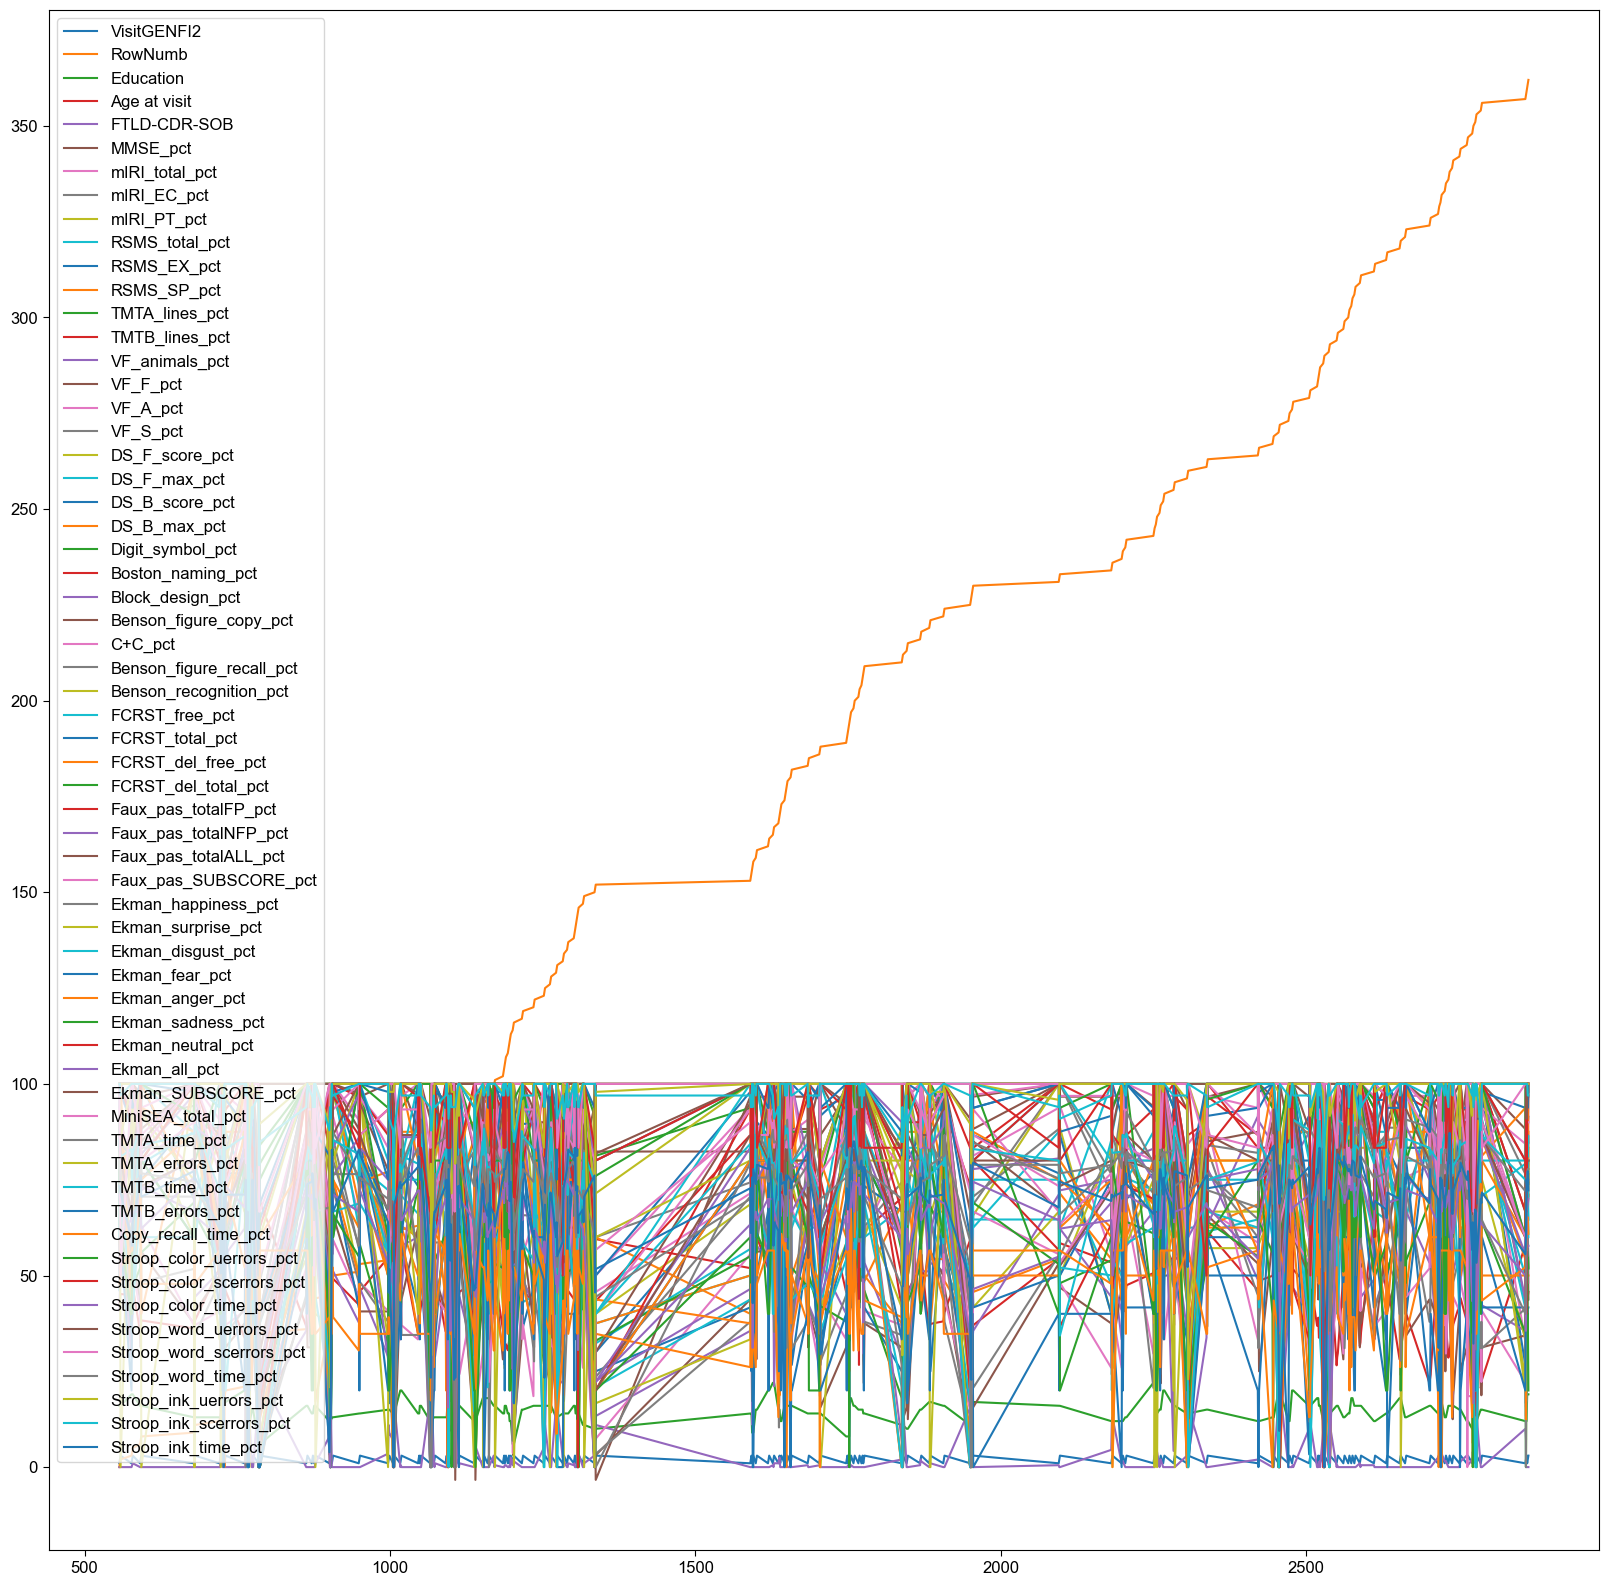

In [112]:
# make a copy of this df before dropping the raw scores
genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_forPCA = genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_1.copy()

# remove the raw score cols using loc
genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_forPCA.drop(genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_forPCA.loc[:, "MMSE":"MiniSEA_total"], axis=1, inplace=True)

# check for duplicate cols
genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_forPCA.columns.duplicated()

# remove the _rev suffix from the trails, stroop ... cols
genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_forPCA.columns = genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_forPCA.columns.str.rstrip("_rev")

# plot data distribution
genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_forPCA.plot()

Now I remove the first few ID columns and row number and related vars and all thsoe data can be entered into a PCA in the below steps.

### Analyses of group differences

Before PCA, I run the standard group difference analyses and copy these information into a Manuscript document in C:\Users\sr06\ownCloud\Projects\In Progress\GENFI_JBR\Manuscript.

### Component selection for PCA (code for MATLAB component separately stored)

Before I run PCA on the data, I need to estimate how many components the dataset has. For this, I will split make 2 versions of the data. The first version is as is, and in the second version, I will split the data into each time point. I will then enter all the data into MATLAB. Once this is done, I will import the data into this notebook for viz. Below, I make the copies of my df and write it as an excel sheet.

I have run this code and the output has been saved in the C:\Users\sr06\ownCloud\Projects\In Progress\GENFI_JBR\Data\CompselInput folder. For now, I am commenting out this code as I don't want it to produce new files every time. The data have been moved to the Data folder and a copy to \\cbsu\data\Group\MLR-Lab\Sid\OngoingProjects as this is where I will need to run the Component Selection code from (HPC cluster has access to this folder only).

In [39]:
# for all time points
#genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_forPCA.to_csv("GENFI2_alltimepoints_forComponentSelection.csv", index=False)

# for T1
#genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_forPCA.loc[genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_forPCA["VisitGENFI2"] == 1].to_csv("GENFI2_T1_forComponentSelection.csv", index=False)

# for T2
#genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_forPCA.loc[genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_forPCA["VisitGENFI2"] == 2].to_csv("GENFI2_T2_forComponentSelection.csv", index=False)

# for T3
#genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_forPCA.loc[genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_forPCA["VisitGENFI2"] == 3].to_csv("GENFI2_T3_forComponentSelection.csv", index=False)

I now import these outputs from Component Selection back into this notebook to visualise and plot.

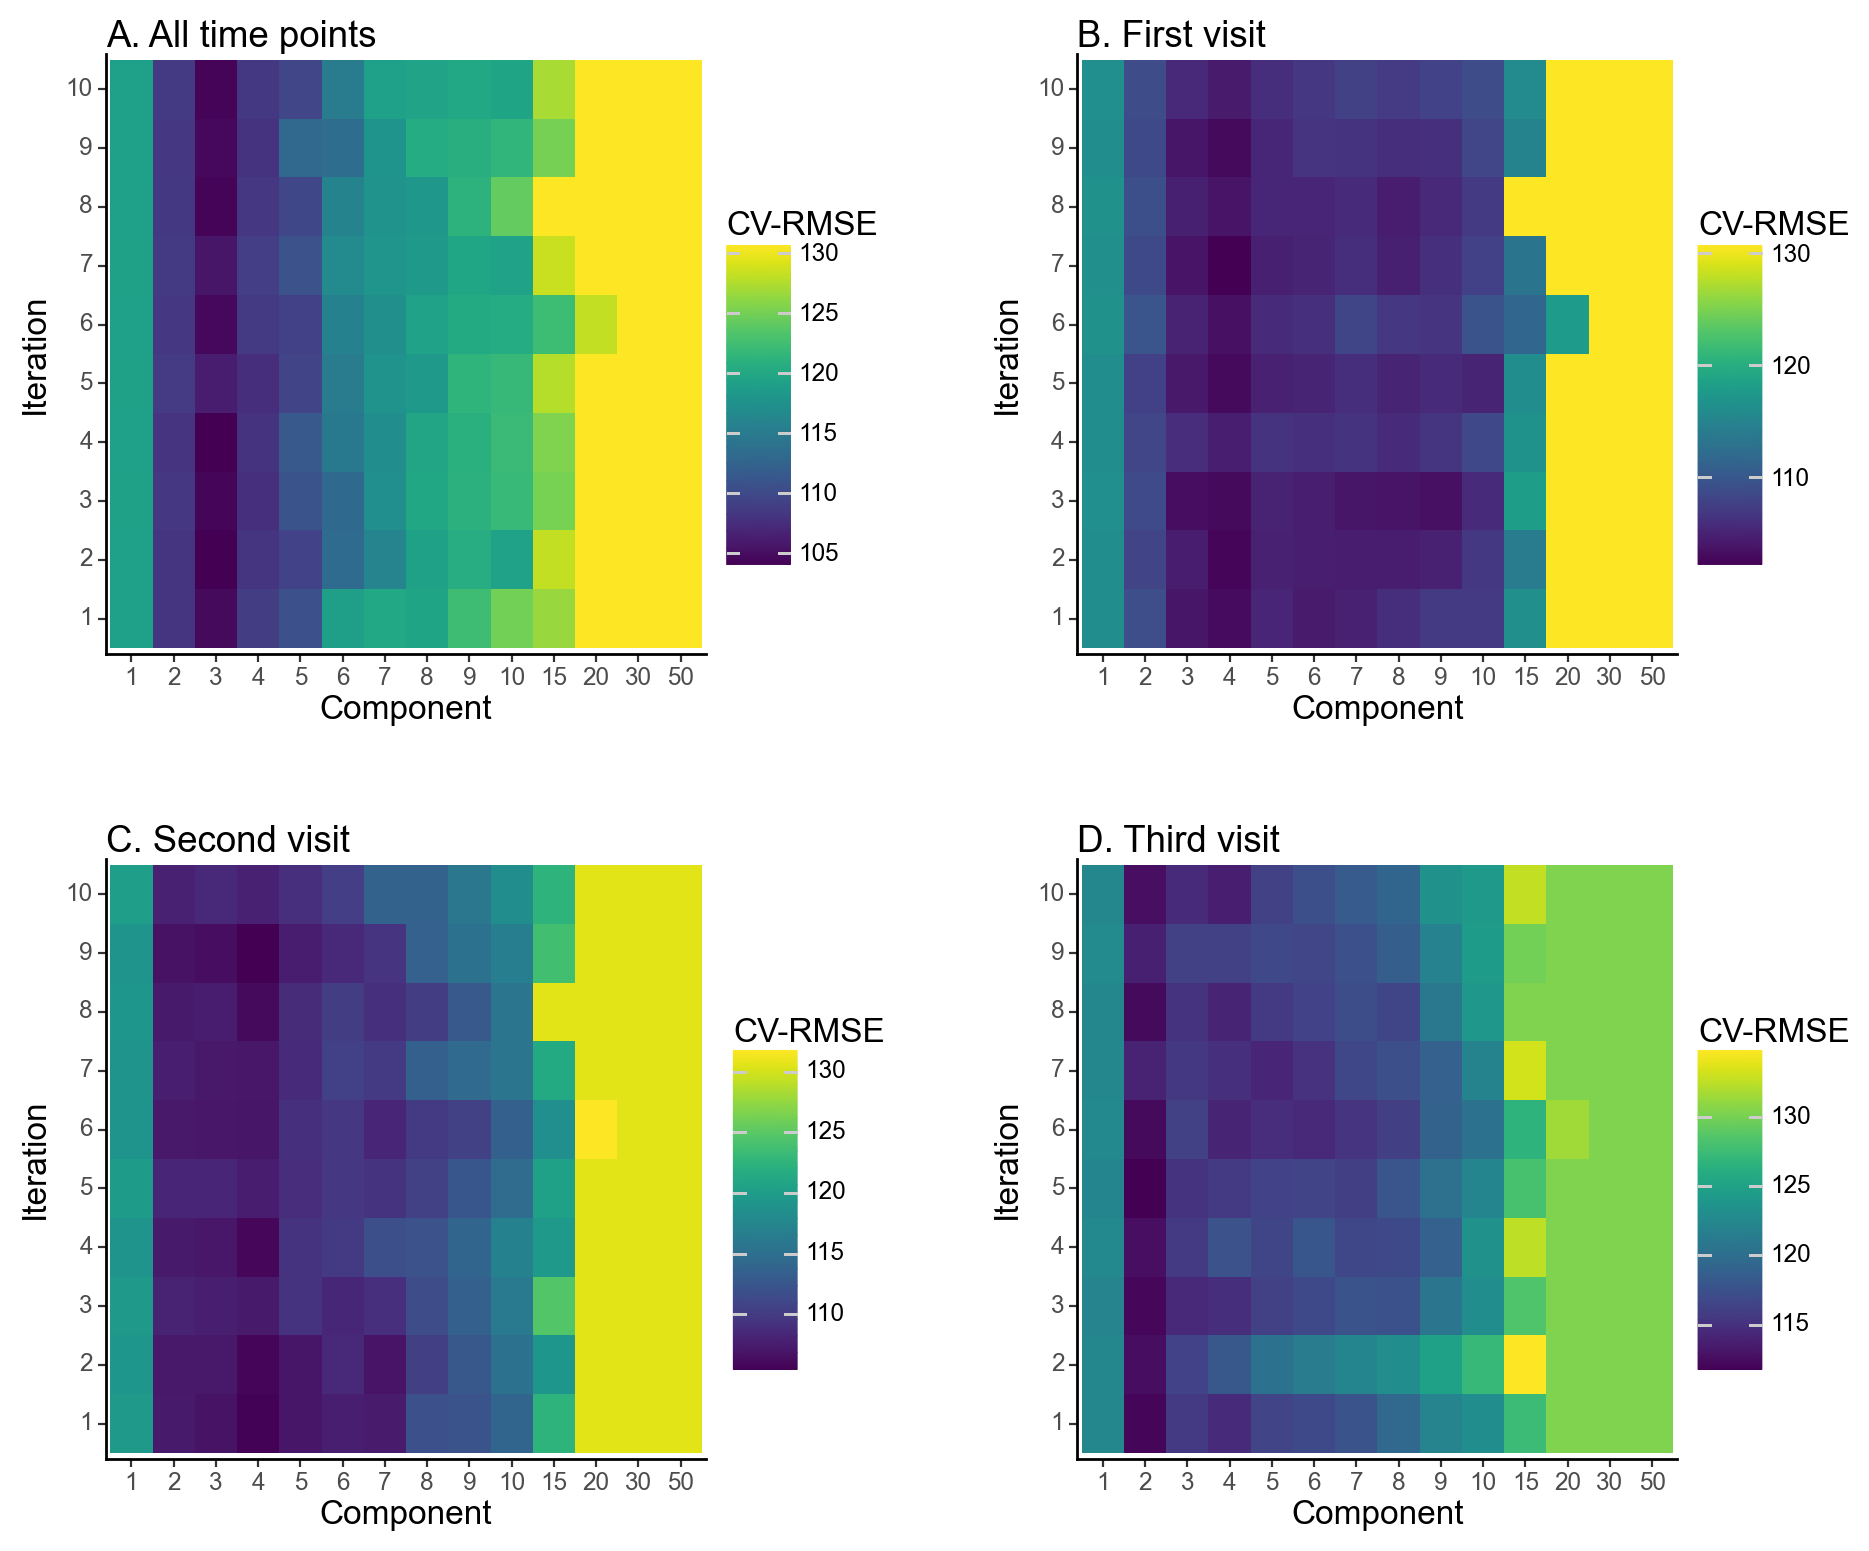

In [40]:
# read in data for all time point and each time point
genfi_compsel_alltimepoints = pd.read_excel("../Data/CompselOutput/WithoutControls/Compsel_alltimepoints.xlsx")
genfi_compsel_T1 = pd.read_excel("../Data/CompselOutput/WithoutControls/Compsel_T1.xlsx")
genfi_compsel_T2 = pd.read_excel("../Data/CompselOutput/WithoutControls/Compsel_T2.xlsx")
genfi_compsel_T3 = pd.read_excel("../Data/CompselOutput/WithoutControls/Compsel_T3.xlsx")

# Turn each dataset into long format and plot it
genfi_compsel_alltimepoints_melt = pd.melt(genfi_compsel_alltimepoints, id_vars=["Components"]).rename(columns={"Components": "Component", "variable": "Iteration", "value": "CV-RMSE_value"})
genfi_compsel_T1_melt = pd.melt(genfi_compsel_T1, id_vars=["Components"]).rename(columns={"Components": "Component", "variable": "Iteration", "value": "CV-RMSE_value"})
genfi_compsel_T2_melt = pd.melt(genfi_compsel_T2, id_vars=["Components"]).rename(columns={"Components": "Component", "variable": "Iteration", "value": "CV-RMSE_value"})
genfi_compsel_T3_melt = pd.melt(genfi_compsel_T3, id_vars=["Components"]).rename(columns={"Components": "Component", "variable": "Iteration", "value": "CV-RMSE_value"})

# I don't want to plot all the RMSE values so any value over 130, I will truncate it.
genfi_compsel_alltimepoints_melt["CV-RMSE_truncated"] = np.where(genfi_compsel_alltimepoints_melt["CV-RMSE_value"] > 130, 130, genfi_compsel_alltimepoints_melt["CV-RMSE_value"])
genfi_compsel_T1_melt["CV-RMSE_truncated"] = np.where(genfi_compsel_alltimepoints_melt["CV-RMSE_value"] > 130, 130, genfi_compsel_T1_melt["CV-RMSE_value"])
genfi_compsel_T2_melt["CV-RMSE_truncated"] = np.where(genfi_compsel_alltimepoints_melt["CV-RMSE_value"] > 130, 130, genfi_compsel_T2_melt["CV-RMSE_value"])
genfi_compsel_T3_melt["CV-RMSE_truncated"] = np.where(genfi_compsel_alltimepoints_melt["CV-RMSE_value"] > 130, 130, genfi_compsel_T3_melt["CV-RMSE_value"])

# I don't want to show all 70 components, so I'll filter the data to keep only comps 1:10, 15, 20, 30, 50, 70
compstokeep = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 70]

# filter Component rows that are in this list above
genfi_compsel_alltimepoints_melt_1 = genfi_compsel_alltimepoints_melt[genfi_compsel_alltimepoints_melt["Component"].isin(compstokeep)]
genfi_compsel_T1_melt_1 = genfi_compsel_T1_melt[genfi_compsel_T1_melt["Component"].isin(compstokeep)]
genfi_compsel_T2_melt_1 = genfi_compsel_T2_melt[genfi_compsel_T2_melt["Component"].isin(compstokeep)]
genfi_compsel_T3_melt_1 = genfi_compsel_T3_melt[genfi_compsel_T3_melt["Component"].isin(compstokeep)]

# create a multiplot figure using patchwork
p1 = (p9.ggplot(genfi_compsel_alltimepoints_melt_1, aes("factor(Component)", "Iteration", fill="CV-RMSE_truncated"))) + p9.geom_tile() + xlab("Component") + labs(fill="CV-RMSE") + ggtitle("A. All time points") + theme_classic()
p2 = (p9.ggplot(genfi_compsel_T1_melt_1, aes("factor(Component)", "Iteration", fill="CV-RMSE_truncated"))) + p9.geom_tile() + xlab("Component") + labs(fill="CV-RMSE") + ggtitle("B. First visit") + theme_classic()
p3 = (p9.ggplot(genfi_compsel_T2_melt_1, aes("factor(Component)", "Iteration", fill="CV-RMSE_truncated"))) + p9.geom_tile() + xlab("Component") + labs(fill="CV-RMSE") + ggtitle("C. Second visit") + theme_classic()
p4 = (p9.ggplot(genfi_compsel_T3_melt_1, aes("factor(Component)", "Iteration", fill="CV-RMSE_truncated"))) + p9.geom_tile() + xlab("Component") + labs(fill="CV-RMSE") + ggtitle("D. Third visit") + theme_classic()

p1 = pw.load_ggplot(p1, figsize=(3,3))
p2 = pw.load_ggplot(p2, figsize=(3,3))
p3 = pw.load_ggplot(p3, figsize=(3,3))
p4 = pw.load_ggplot(p4, figsize=(3,3))

p1234 = (p1|p2)/(p3|p4)
p1234
#p1234.savefig("Compsel.tiff") # commenting this out so it doesn't keep saving the figure everytime I run the kernel
#p1234.savefig("Compsel.jpg") # commenting this out so it doesn't keep saving the figure everytime I run the kernel

From the above plot, it looks like 3-4 components emerge at all time points as the most optimal solution. I will now run a varimax PCA on all the time points together using a 3 and a 4 component solution.

### PCA on behavioural data (symptomatic and asymptomatic combined)

The data are ready to go into the PCA. I will remove the ID columns and then feed the data into the PCA.

Note: Python doesn't have a varimax rotated PCA option but it has a package called FactorAnalyzer that does a varimax PCA (they call it principal factor analysis). When I was looking up other options, I also came across this code to program varimax code from scratch (https://en.wikipedia.org/wiki/Talk:Varimax_rotation) and implement it on PCA output from sklearn (https://colab.research.google.com/github/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/PCA_Abdi_in_python.ipynb). To check, I will also run varimax PCA on R and see if the output is the same as FactorAnalyzer.

In [113]:
# create a meta ID column
genfi2_forPCA_meta = genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_forPCA[['Genetic Group', 'VisitGENFI2', 'RowNumb', 'Gend', 'Education', 'Age at visit', 'FTLD-CDR-SOB']]

# make a list of meta columns that we have kept
meta_cols_to_remove = ['Genetic Group', 'VisitGENFI2', 'RowNumb', 'Gend', 'Education', 'Age at visit', 'FTLD-CDR-SOB']

# remove these columns and make a copy of the df
genfi2_enterintoPCA = genfi_GENFI2_3tp_neuropsych_final_imputed_prePCA_forPCA.drop(['Genetic Group', 'VisitGENFI2', 'RowNumb', 'Gend', 'Education', 'Age at visit', 'FTLD-CDR-SOB'], axis=1).copy()

# create a list of the test names that can be merged with the loadings later
test_names = pd.DataFrame(genfi2_enterintoPCA.columns.values)

# add a row number as identifier
test_names["RowNumber"] = range(len(test_names))

# remove "_pct" as a string from the column
test_names[0] = test_names[0].map(lambda x: x.rstrip('_pct'))

#### Examine PCA structure and loadings

##### 3 component PCA and loadings

In [ ]:
pca_genfi2_3comp = FactorAnalyzer(n_factors=3, method='principal', rotation='varimax')
pca_genfi2_3comp.fit(genfi2_enterintoPCA)

# extract loadings
pca_genfi2_3comp_loadings = pd.DataFrame(pca_genfi2_3comp.loadings_.round(2))

# assign row number
pca_genfi2_3comp_loadings["RowNumber"] = range(len(pca_genfi2_3comp_loadings))

# merge with test names
pca_genfi2_3comp_loadingstests = test_names.merge(pca_genfi2_3comp_loadings, on="RowNumber")

# rename columns
pca_genfi2_3comp_loadingstests.rename(columns={"0_x": "Measure", 
                                               "0_y": "PC1", 
                                              1: "PC2",
                                              2: "PC3"}, inplace=True)

# pivot to long format
pca_genfi2_3comp_loadingstests_long = pd.melt(pca_genfi2_3comp_loadingstests, id_vars=["RowNumber", "Measure"])

# plot
plot_pca3comp = (ggplot(pca_genfi2_3comp_loadingstests_long, aes(y="value", x="Measure"))) + geom_bar(stat='identity', position='identity') + coord_flip() + facet_wrap("variable") + geom_hline(yintercept = .5, colour='red', linetype='dashed') + theme_bw() + xlab('Component Loadings') + ylab('Measures') 
plot_pca3comp = pw.load_ggplot(plot_pca3comp, figsize=(5,8))
plot_pca3comp
#plot_pca3comp.savefig("PCA_Loadings_3comp.tiff") # commenting this out so it doesn't keep saving the figure everytime I run the kernel

Check whether the same output emerges when we use principal in R. Finding: it is the same so I can go ahead and use FactorAnalyzer.

In [166]:
%%R -i genfi2_enterintoPCA

# run PCA
r_pca_genfi2_3comp <- psych::principal(genfi2_enterintoPCA, nfactors=3, rotate="varimax")

# extract loadings, scores, varexp and save as df
r_pca_genfi2_3comp_loadings <- as.data.frame.matrix(r_pca_genfi2_3comp$loadings)
r_pca_genfi2_3comp_scores <- as.data.frame.matrix(r_pca_genfi2_3comp$scores)
r_pca_genfi2_3comp_vexp <- as.data.frame.matrix(r_pca_genfi2_3comp$Vaccounted)
# output between r_pca_genfi2_3comp_loadings and pca_genfi2_3comp_loadingstests is the same

# rename columns
#r_pca_genfi2_3comp_loadings <- setNames(cbind(rownames(r_pca_genfi2_3comp_loadings), r_pca_genfi2_3comp_loadings, row.names = NULL), 
#         c("Measures", "PC1", "PC2", "PC3"))
#r_pca_genfi2_3comp_scores <- setNames(cbind(rownames(r_pca_genfi2_3comp_scores), r_pca_genfi2_3comp_scores, row.names = NULL), 
#         c("ID", "PC1", "PC2", "PC3"))
#r_pca_genfi2_3comp_vexp <- setNames(cbind(rownames(r_pca_genfi2_3comp_vexp), r_pca_genfi2_3comp_vexp, row.names = NULL), 
#         c("Variance", "PC1", "PC2", "PC3"))

##### 4 component PCA and loadings

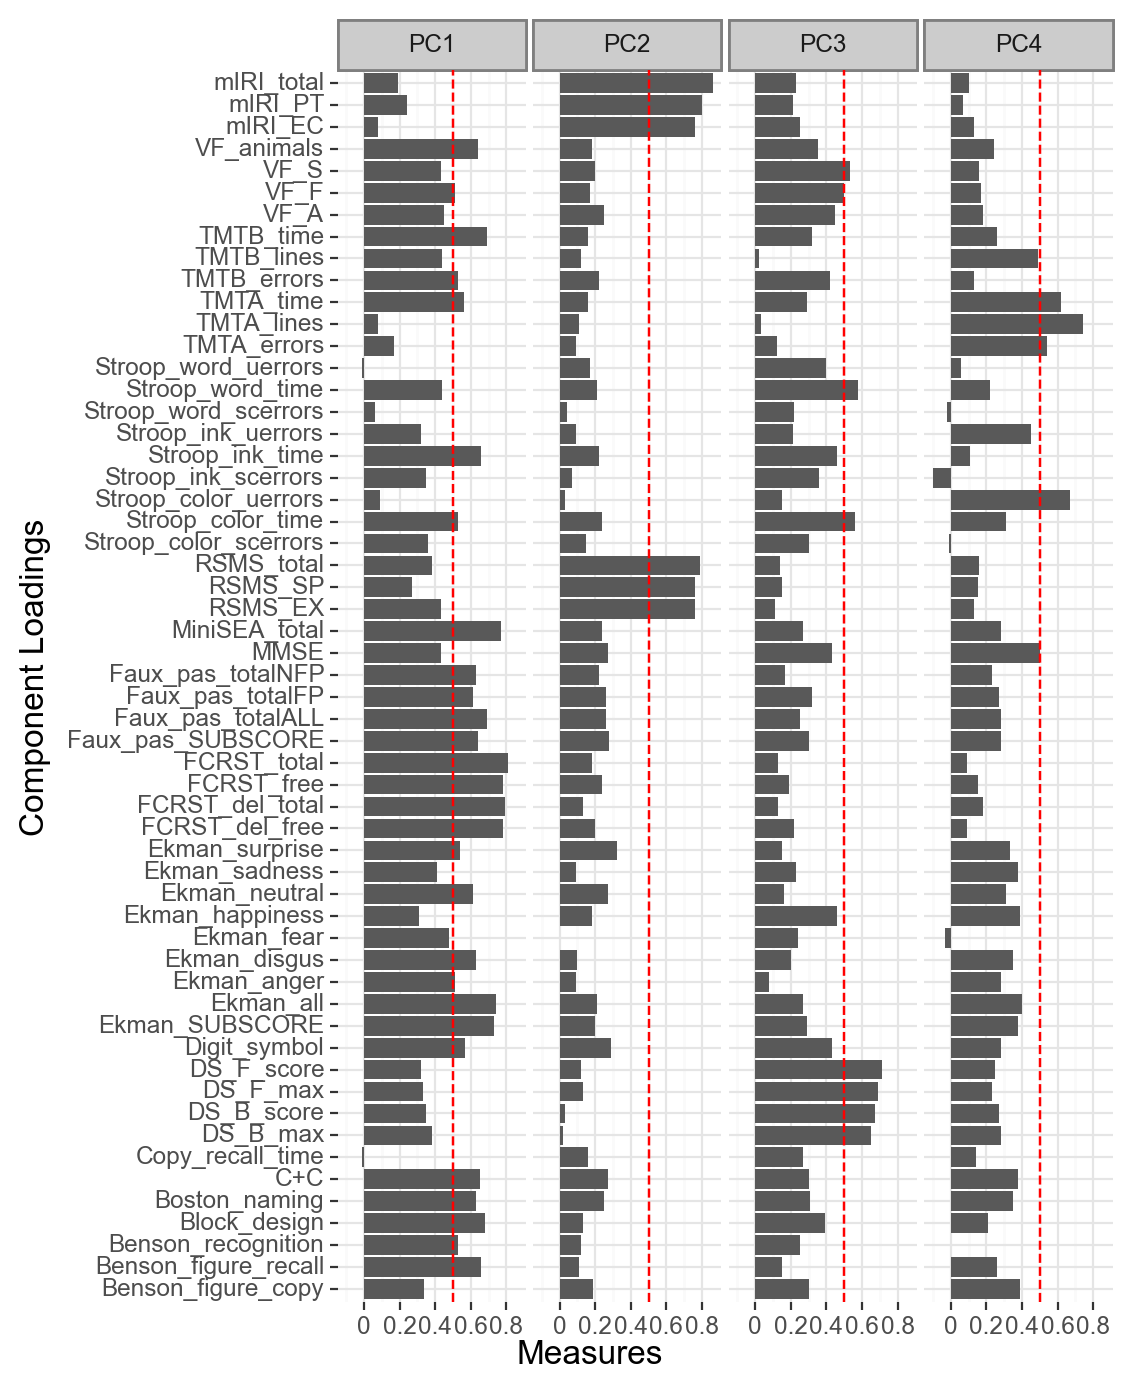

In [44]:
# use factor analyser to do a 3 component pca with varimax rotation
pca_genfi2_4comp = FactorAnalyzer(n_factors=4, method='principal', rotation='varimax')
pca_genfi2_4comp.fit(genfi2_enterintoPCA)

# extract loadings
pca_genfi2_4comp_loadings = pd.DataFrame(pca_genfi2_4comp.loadings_.round(2))

# assign row number
pca_genfi2_4comp_loadings["RowNumber"] = range(len(pca_genfi2_4comp_loadings))

# merge with test names
pca_genfi2_4comp_loadingstests = test_names.merge(pca_genfi2_4comp_loadings, on="RowNumber")

# rename columns
pca_genfi2_4comp_loadingstests.rename(columns={"0_x": "Measure", 
                                               "0_y": "PC1", 
                                              1: "PC2",
                                              2: "PC3",
                                              3: "PC4"}, inplace=True)

# pivot to long format
pca_genfi2_4comp_loadingstests_long = pd.melt(pca_genfi2_4comp_loadingstests, id_vars=["RowNumber", "Measure"])

# plot
plot_pca4comp = (ggplot(pca_genfi2_4comp_loadingstests_long, aes(y="value", x="Measure"))) + geom_bar(stat='identity', position='identity') + coord_flip() + facet_wrap("variable", nrow=1) + geom_hline(yintercept = .5, colour='red', linetype='dashed') + theme_bw() + xlab('Component Loadings') + ylab('Measures') 
plot_pca4comp = pw.load_ggplot(plot_pca4comp, figsize=(5,8))
plot_pca4comp
#plot_pca4comp.savefig("PCA_Loadings_4comp.jpg") # commenting this out so it doesn't keep saving the figure everytime I run the kernel

In [168]:
pca_genfi2_4comp_loadingstests

Measure  RowNumber   PC1   PC2   PC3   PC4
0                    MMSE          0  0.43  0.27  0.43  0.50
1              mIRI_total          1  0.19  0.86  0.23  0.10
2                 mIRI_EC          2  0.08  0.76  0.25  0.13
3                 mIRI_PT          3  0.24  0.80  0.21  0.07
4              RSMS_total          4  0.38  0.79  0.14  0.16
5                 RSMS_EX          5  0.43  0.76  0.11  0.13
6                 RSMS_SP          6  0.27  0.76  0.15  0.15
7              TMTA_lines          7  0.08  0.11  0.03  0.74
8              TMTB_lines          8  0.44  0.12  0.02  0.49
9              VF_animals          9  0.64  0.18  0.35  0.24
10                   VF_F         10  0.51  0.17  0.50  0.17
11                   VF_A         11  0.45  0.25  0.45  0.18
12                   VF_S         12  0.43  0.20  0.53  0.16
13             DS_F_score         13  0.32  0.12  0.71  0.25
14               DS_F_max         14  0.33  0.13  0.69  0.23
15             DS_B_score         15  0.35  0.03  0.67  0.27
16               DS_B_max         16  0.38  0.02  0.65  0.28
17           Digit_symbol         17  0.57  0.29  0.43  0.28
18          Boston_naming         18  0.63  0.25  0.31  0.35
19           Block_design         19  0.68  0.13  0.39  0.21
20     Benson_figure_copy         20  0.34  0.19  0.30  0.39
21                    C+C         21  0.65  0.27  0.30  0.38
22   Benson_figure_recall         22  0.66  0.11  0.15  0.26
23     Benson_recognition         23  0.53  0.12  0.25 -0.00
24             FCRST_free         24  0.78  0.24  0.19  0.15
25            FCRST_total         25  0.81  0.18  0.13  0.09
26         FCRST_del_free         26  0.78  0.20  0.22  0.09
27        FCRST_del_total         27  0.79  0.13  0.13  0.18
28       Faux_pas_totalFP         28  0.61  0.26  0.32  0.27
29      Faux_pas_totalNFP         29  0.63  0.22  0.17  0.23
30      Faux_pas_totalALL         30  0.69  0.26  0.25  0.28
31      Faux_pas_SUBSCORE         31  0.64  0.28  0.30  0.28
32        Ekman_happiness         32  0.31  0.18  0.46  0.39
33         Ekman_surprise         33  0.54  0.32  0.15  0.33
34           Ekman_disgus         34  0.63  0.10  0.20  0.35
35             Ekman_fear         35  0.48  0.00  0.24 -0.03
36            Ekman_anger         36  0.51  0.09  0.08  0.28
37          Ekman_sadness         37  0.41  0.09  0.23  0.38
38          Ekman_neutral         38  0.61  0.27  0.16  0.31
39              Ekman_all         39  0.74  0.21  0.27  0.40
40         Ekman_SUBSCORE         40  0.73  0.20  0.29  0.38
41          MiniSEA_total         41  0.77  0.24  0.27  0.28
42              TMTA_time         42  0.56  0.16  0.29  0.62
43            TMTA_errors         43  0.17  0.09  0.12  0.54
44              TMTB_time         44  0.69  0.16  0.32  0.26
45            TMTB_errors         45  0.53  0.22  0.42  0.13
46       Copy_recall_time         46 -0.01  0.16  0.27  0.14
47   Stroop_color_uerrors         47  0.09  0.03  0.15  0.67
48  Stroop_color_scerrors         48  0.36  0.15  0.30 -0.01
49      Stroop_color_time         49  0.53  0.24  0.56  0.31
50    Stroop_word_uerrors         50 -0.01  0.17  0.40  0.06
51   Stroop_word_scerrors         51  0.06  0.04  0.22 -0.02
52       Stroop_word_time         52  0.44  0.21  0.58  0.22
53     Stroop_ink_uerrors         53  0.32  0.09  0.21  0.45
54    Stroop_ink_scerrors         54  0.35  0.07  0.36 -0.10
55        Stroop_ink_time         55  0.66  0.22  0.46  0.11

Check whether same output emerges using principal in R

In [170]:
%%R -i genfi2_enterintoPCA

# run PCA
r_pca_genfi2_4comp <- psych::principal(genfi2_enterintoPCA, nfactors=4, rotate="varimax")

# extract loadings, scores, varexp and save as df
r_pca_genfi2_4comp_loadings <- as.data.frame.matrix(r_pca_genfi2_4comp$loadings)
r_pca_genfi2_4comp_scores <- as.data.frame.matrix(r_pca_genfi2_4comp$scores)
r_pca_genfi2_4comp_vexp <- as.data.frame.matrix(r_pca_genfi2_4comp$Vaccounted)
# output between r_pca_genfi2_4comp_loadings and pca_genfi2_4comp_loadingstests is the same

# rename columns
#r_pca_genfi2_4comp_loadings <- setNames(cbind(rownames(r_pca_genfi2_4comp_loadings), r_pca_genfi2_4comp_loadings, row.names = NULL), 
#         c("Measures", "PC1", "PC2", "PC3", "PC4"))
#r_pca_genfi2_4comp_scores <- setNames(cbind(rownames(r_pca_genfi2_4comp_scores), r_pca_genfi2_4comp_scores, row.names = NULL), 
#         c("ID", "PC1", "PC2", "PC3", "PC4"))
#r_pca_genfi2_4comp_vexp <- setNames(cbind(rownames(r_pca_genfi2_4comp_vexp), r_pca_genfi2_4comp_vexp, row.names = NULL), 
#         c("Variance", "PC1", "PC2", "PC3", "PC4"))

Note, as the PCA output between both R and FactorAnalyzer in python are the same, I'll go ahead and use the Python output.

#### PCA checks: communality

Check if any communality == 0 or == 1. If == 0 then the variable completely unexplained by other variables. If == 1 then it has no unique variance at all. As the values as in decimals, I'll check for communalities <.1 and >.9 to ensure I don't miss out values that border these cut-offs.

In [171]:
# any communalities == 0?
pca_genfi2_3comp.get_communalities() <.1
pca_genfi2_4comp.get_communalities() <.1
# all ok

# any communalities == 1?
pca_genfi2_3comp.get_communalities() >.9
pca_genfi2_4comp.get_communalities() >.9
# all ok

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

#### PCA checks: eigenvalues

Below, I extract eigenvalues and plot it. Eigenvalues are unchanged for either the 3comp or 4comp solution so I will use any of these measures to extract these vals.

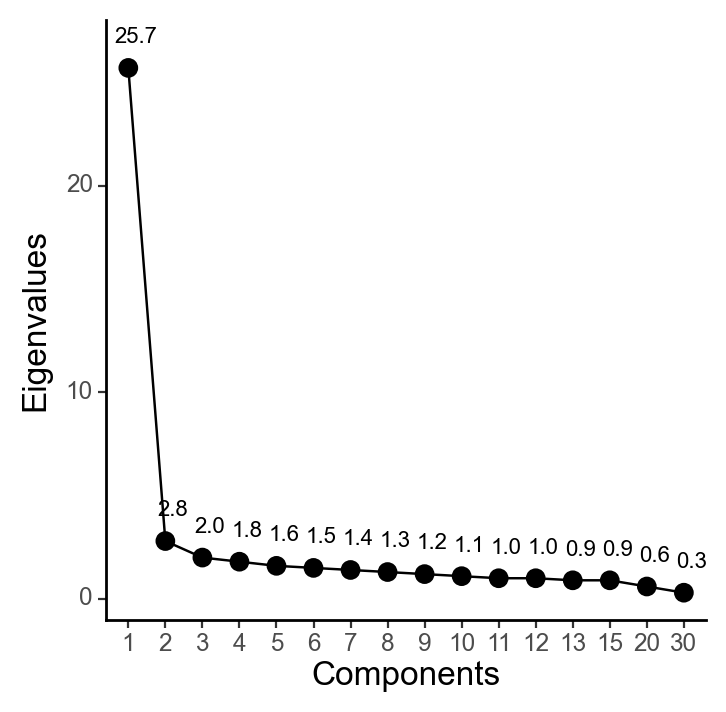

In [172]:
# get eigenvalues as a df
pca_genfi2_eigenval = pd.DataFrame(pca_genfi2_4comp.get_eigenvalues())
# note, this command produces two sets of eigenvalues, one for the original eigenvalues and the second is common factor eigenvalues

# transpose this df
pca_genfi2_eigenval = pca_genfi2_eigenval.T

# add a variable for component number for each eigenvalue
pca_genfi2_eigenval.insert(0, "Components", range(1, 1+len(pca_genfi2_eigenval)))

# change col names
pca_genfi2_eigenval.rename(columns={0: "Eigenvalues", 
                                              1: "CommonFactorEigenvalues"
                                              }, inplace=True)

# round these values into 2 decimals points and absolute values (there are some values with -0.0)
pca_genfi2_eigenval["Eigenvalues"] = pca_genfi2_eigenval["Eigenvalues"].round(1).abs()
pca_genfi2_eigenval["CommonFactorEigenvalues"] = pca_genfi2_eigenval["CommonFactorEigenvalues"].round(1).abs()

# I don't want to show all 70 components, so I'll filter the data to keep only comps 1:13, 15
compstokeep = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 20, 30]

# filter Component rows that are in this list above
pca_genfi2_eigenval = pca_genfi2_eigenval[pca_genfi2_eigenval["Components"].isin(compstokeep)]

# change Component into factor so its easier to plot
pca_genfi2_eigenval["Components"] = pca_genfi2_eigenval["Components"].astype("category")

# plot eigenvalues
ploteigen = (ggplot(pca_genfi2_eigenval, aes("factor(Components)", "Eigenvalues", group=1))) + geom_point(size = 3) + geom_line() + geom_text(data=pca_genfi2_eigenval,
                 mapping=aes(x="Components", y="Eigenvalues", label="Eigenvalues"), nudge_y=1, nudge_x=0.2, va="bottom", size=8) + xlab("Components") + theme_classic()
ploteigen = pw.load_ggplot(ploteigen, figsize=(3,3))
ploteigen
#ploteigen.savefig("Eigenvalues.tiff") # commenting this out so it doesn't keep saving the figure everytime I run the kernel
#ploteigen.savefig("Eigenvalues.jpg") # commenting this out so it doesn't keep saving the figure everytime I run the kernel

#### PCA checks: KMO

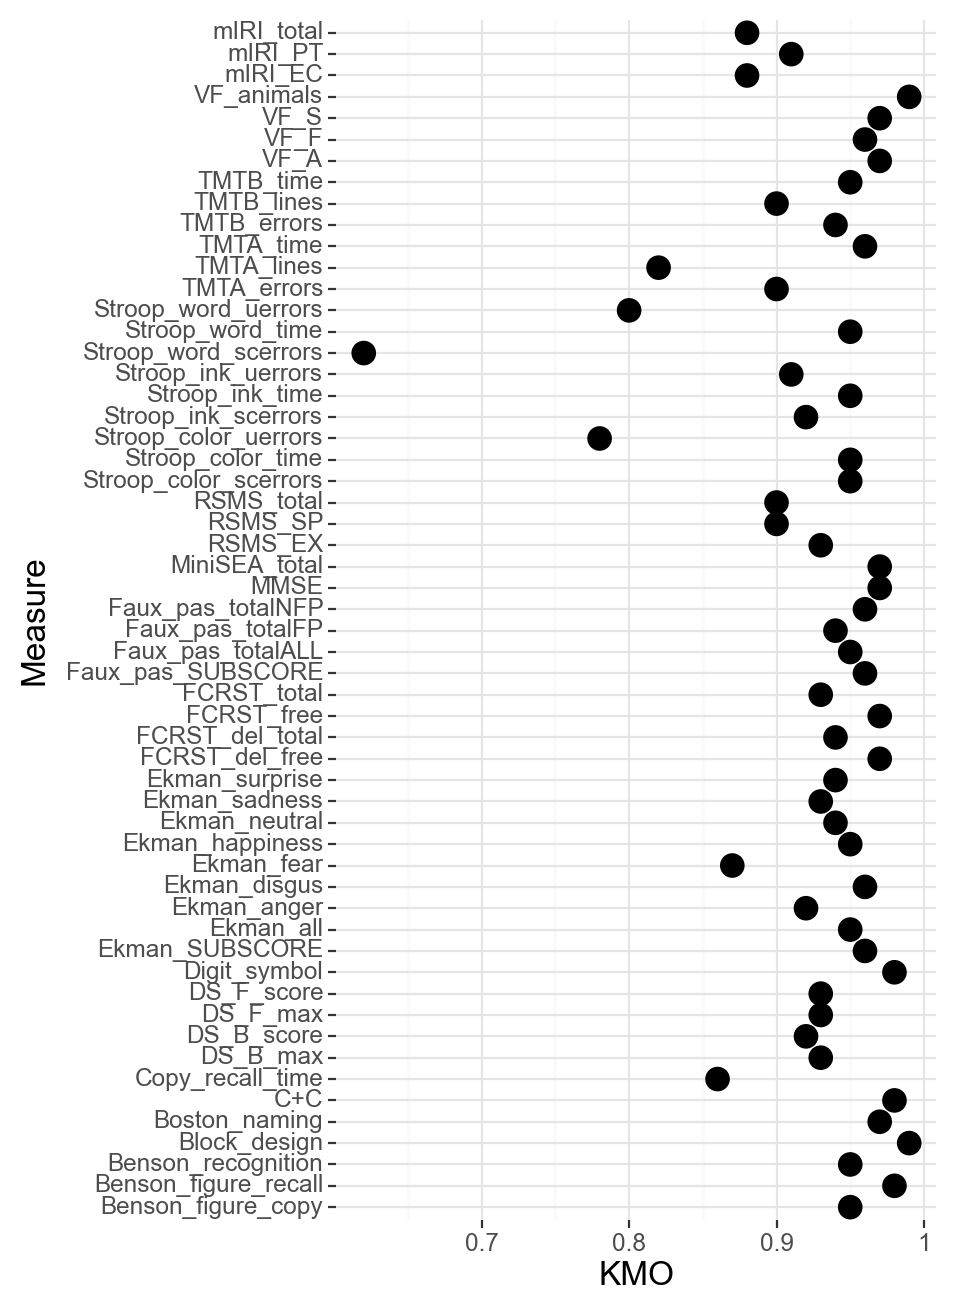

In [175]:
# KMO is produced as an array for every item (col 1) and the average (col 2)
# extracting the average KMO:
calculate_kmo(genfi2_enterintoPCA)[1]
# 0.9441306556662611

# extracting itemwise KMO and plotting it
item_kmo = pd.DataFrame(calculate_kmo(genfi2_enterintoPCA)[0].round(2))

# add a row number
item_kmo["RowNumber"] = range(len(item_kmo))

# merge test names
item_kmo_tests = test_names.merge(item_kmo, on="RowNumber")

# rename columns
item_kmo_tests.rename(columns={"0_x": "Measure",
                              "0_y": "KMO"}, inplace=True)

# plot as a line graph
plotkmo = (ggplot(item_kmo_tests, aes(x="KMO", y="Measure")))  + geom_point(size = 4) +  theme_bw()
plotkmo = pw.load_ggplot(plotkmo, figsize=(3,6))
plotkmo
#plotkmo.savefig("KMO.jpg") # commenting this out so it doesn't keep saving the figure everytime I run the kernel
#plotkmo.savefig("KMO.tiff") # commenting this out so it doesn't keep saving the figure everytime I run the kernel

#### PCA plot: variance explained

Extract explained variance and cumulative variance for each solution.

##### 3 component solution

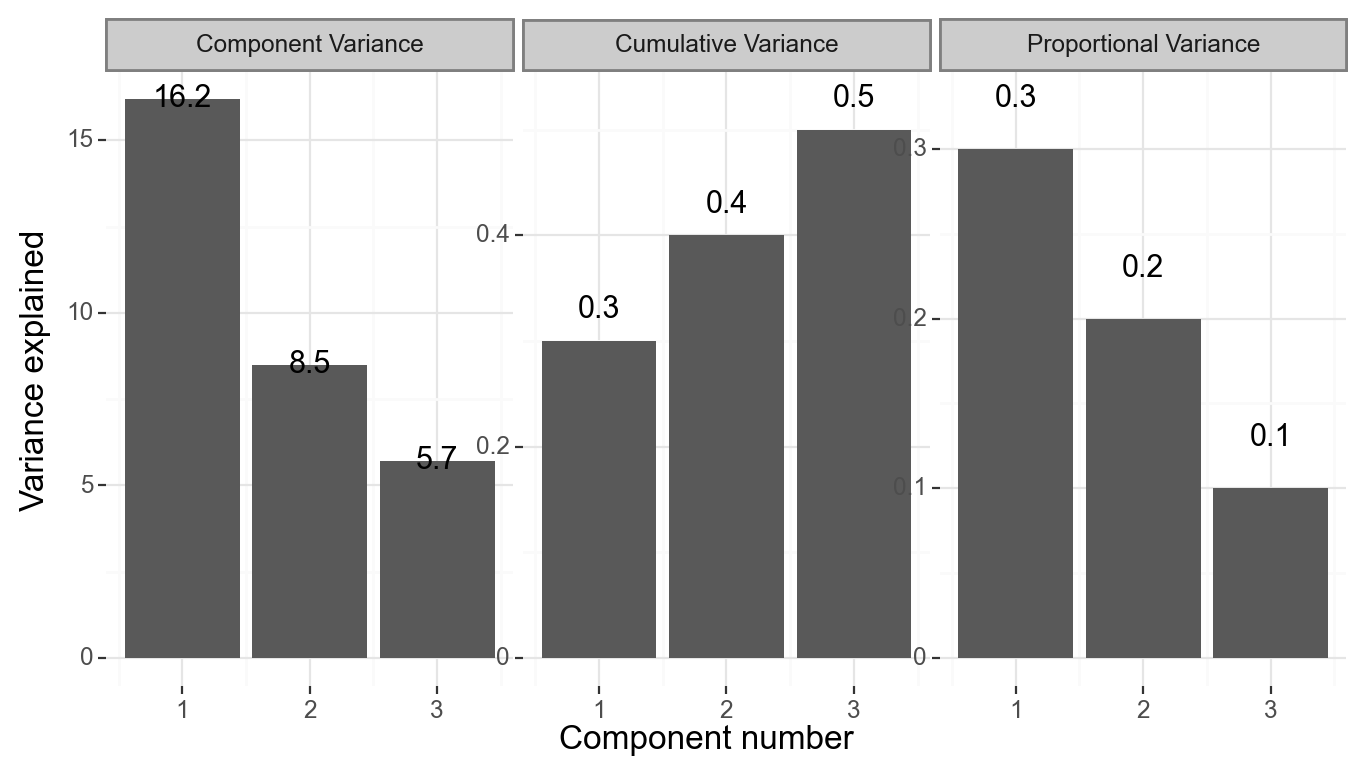

In [188]:
# get variances
compvar_3comp = pca_genfi2_3comp.get_factor_variance()[0].round(1) # component specific variance
propvar_3comp = pca_genfi2_3comp.get_factor_variance()[1].round(1) # proportional variance
cumvar_3comp = pca_genfi2_3comp.get_factor_variance()[2].round(1) # cumulative variance

# note that for compvar and propvar arrays, the order for PC2 and PC3 is reversed
# I index the position of PC2 and PC3 and rearrange these arrays per the index
idx = [0, 2, 1]
compvar_3comp = compvar_3comp[idx]
propvar_3comp = propvar_3comp[idx]

# save into a df
pcavarexp_3comp = pd.DataFrame({"Component Variance": compvar_3comp, "Proportional Variance": propvar_3comp, "Cumulative Variance": cumvar_3comp},
                                columns=["Component Variance", "Proportional Variance", "Cumulative Variance"])

# add a component number
pcavarexp_3comp["Component"] = [1, 2, 3]

# melt this dataset
pcavarexp_3comp_melt = pd.melt(pcavarexp_3comp, id_vars="Component")

# plot
varexp_3comp = (ggplot(pcavarexp_3comp_melt, aes(x="Component", y="value"))) + geom_col() + facet_wrap("variable", scales="free") + geom_text(aes(label = "value"), position = position_dodge(width=.75), nudge_y = 0.03) + theme_bw() + xlab('Component number') + ylab('Variance explained')
varexp_3comp = pw.load_ggplot(varexp_3comp, figsize=(8,4))
varexp_3comp
#varexp_3comp.savefig("VarianceExplained_3comp.jpg") # commenting this out so it doesn't keep saving the figure everytime I run the kernel


##### 4 component solution

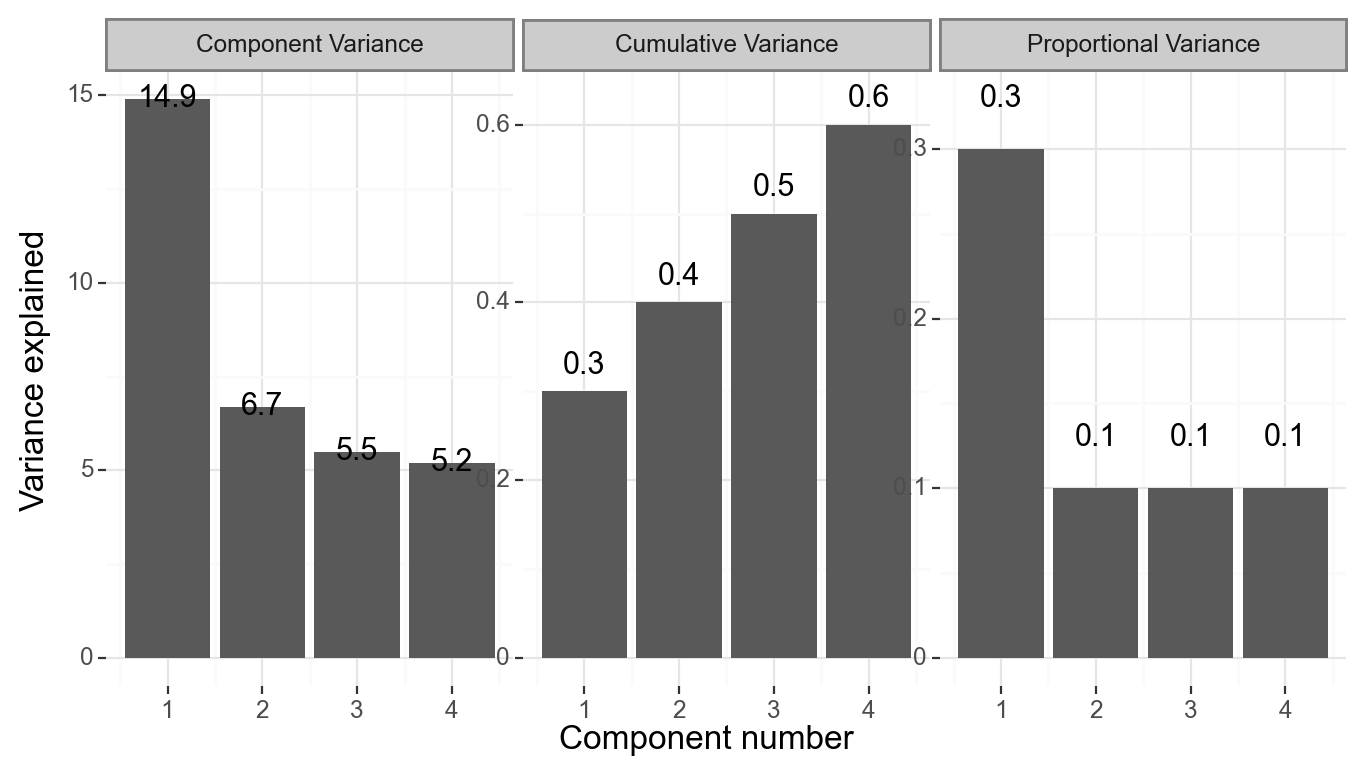

In [192]:
# get variances
compvar_4comp = pca_genfi2_4comp.get_factor_variance()[0].round(1) # component specific variance
propvar_4comp = pca_genfi2_4comp.get_factor_variance()[1].round(1) # proportional variance
cumvar_4comp = pca_genfi2_4comp.get_factor_variance()[2].round(1) # cumulative variance

# note that for compvar and propvar arrays, the order for PC2 and PC3 is reversed
# I index the position of PC2 and PC3 and rearrange these arrays per the index
idx = [0, 2, 1, 3]
compvar_4comp = compvar_4comp[idx]
propvar_4comp = propvar_4comp[idx]

# save into a df
pcavarexp_4comp = pd.DataFrame({"Component Variance": compvar_4comp, "Proportional Variance": propvar_4comp, "Cumulative Variance": cumvar_4comp},
                                columns=["Component Variance", "Proportional Variance", "Cumulative Variance"])

# add a component number
pcavarexp_4comp["Component"] = [1, 2, 3, 4]

# melt this dataset
pcavarexp_4comp_melt = pd.melt(pcavarexp_4comp, id_vars="Component")

# plot
varexp_4comp = (ggplot(pcavarexp_4comp_melt, aes(x="Component", y="value"))) + geom_col() + facet_wrap("variable", scales="free") + geom_text(aes(label = "value"), position = position_dodge(width=.75), nudge_y = 0.03) + theme_bw() + xlab('Component number') + ylab('Variance explained')
varexp_4comp = pw.load_ggplot(varexp_4comp, figsize=(8,4))
varexp_4comp
#varexp_4comp.savefig("VarianceExplained_4comp.jpg") # commenting this out so it doesn't keep saving the figure everytime I run the kernel

#### PCA plot: Scores

### Modelling calendar time in an alternate manner

In my meeting with MALR on 19/7/23, we discussed alternate ways of modelling disease severity over time. The main motivation for this is that the current measure of calendar years or rounds of testing models time in very static manners. Often, some diseases progress faster than others and vice versa, which means that if we choose a time point cut off of 3 years (like what we have done here), we risk modelling some patients who could only do 3 assessments - so by the time of their last assessment, they are already quite impaired. On the other hand, slow progressive diseases may come for more assessments. This variability in time can be modelled using some alternate ways that we can then use as a complementary variable to model time in these patients. We think it can be done in the following way:
1. In all patients (i.e., GENFI2 but before culling down to those with 3 time point data), we take their neuropsych data and trim out cases that have lots of missing data in their last round. This way, we preserve as much data as possible.
2. We can be more tolerant of missing data in this analysis as the goal is to estimate an alterate metric of disease progression to complement time. For the missing data, we impute it using MICE as before.
3. We enter all data into a PCA and pull out the first fixed factor. This factor will represent a compression of all the data and can be used to stage patients.
4. On this continuous first factor PCA scale, we can try some classification/clustering to bin it into 5-10 data-driven bins. 
5. We can then project the calendar year or testing round into these bins to see what the overlap looks like. I was also thinking we can feed the fixed factor PCA into some sort of classification algorithm via XGBoost and map it on the testing rounds.

Once we do this, we will have an idea of whether calendar years accurately capture fast vs. slow progressors. 
Lets try this out.


In [ ]:
# use this dataframe and call it ddtime for datadriventime
genfi_behav_dropkey_ddtime = genfi_behav_dropkey.copy()

# rename blinded code to ID
genfi_behav_dropkey_ddtime.rename(columns={"Blinded Code": "ID", "Visit": "VisitNumber"}, inplace=True)

# create a new Visit variable for GENFI2
genfi_behav_dropkey_ddtime["VisitGENFI2"] = genfi_behav_dropkey_ddtime.groupby("ID").cumcount()+1

# remove non-carriers (these are controls so I don't want to keep them in)
genfi_behav_dropkey_ddtime = genfi_behav_dropkey_ddtime.drop(genfi_behav_dropkey_ddtime[genfi_behav_dropkey_ddtime["Genetic status 2"] == "Non-carrier"].index)

# create a running row number so we can visualise all IDs
genfi_behav_dropkey_ddtime["RowNumber"] = range(len(genfi_behav_dropkey_ddtime))

# keep only the following cols (including ID)
ColsToKeep = ["ID",
 'Genetic Group',
 'VisitGENFI2',
 'RowNumber',
 'Gender',
 "Education",
 'Age at visit',
 'FTLD-CDR-SOB',
 'MMSE',
 'mIRI_total',
 'mIRI_EC',
 'mIRI_PT',
 'RSMS_total',
 'RSMS_EX',
 'RSMS_SP',
 'DS_F_score',
 'DS_F_max',
 'DS_B_score',
 'DS_B_max',
 'TMTA_time',
 'TMTA_errors',
 'TMTA_lines',
 'TMTB_time',
 'TMTB_errors',
 'TMTB_lines',
 'Digit_symbol',
 'Boston_naming',
 'VF_animals',
 'VF_F',
 'VF_A',
 'VF_S',
 'Block_design',
 'Benson_figure_copy',
 'C+C',
 'Benson_figure_recall',
 'Copy_recall_time',
 'Benson_recognition',
 'FCRST_free',
 'FCRST_total',
 'Stroop_color_uerrors',
 'Stroop_color_scerrors',
 'Stroop_color_time',
 'Stroop_word_uerrors',
 'Stroop_word_scerrors',
 'Stroop_word_time',
 'Stroop_ink_uerrors',
 'Stroop_ink_scerrors',
 'Stroop_ink_time',
 'FCRST_del_free',
 'FCRST_del_total',
 'Faux_pas_totalFP',
 'Faux_pas_totalNFP',
 'Faux_pas_totalALL',
 'Faux_pas_SUBSCORE',
 'Ekman_happiness',
 'Ekman_surprise',
 'Ekman_disgust',
 'Ekman_fear',
 'Ekman_anger',
 'Ekman_sadness',
 'Ekman_neutral',
 'Ekman_all',
 'Ekman_SUBSCORE',
 'MiniSEA_total']

genfi_behav_dropkey_ddtime_1 = genfi_behav_dropkey_ddtime[ColsToKeep].copy()

# check how much missing data is there
genfi_behav_dropkey_ddtime_1.isna().sum().sum() / (genfi_behav_dropkey_ddtime_1.shape[0] * genfi_behav_dropkey_ddtime_1.shape[1])
# if I remove the ID, Gender etc. variables, the value goes up to 22% so its ok I think.

# calculate the percentage of missing values for each ID for each time point
genfi_behav_dropkey_ddtime_1["PercentMissing"] = genfi_behav_dropkey_ddtime_1.isnull().sum(axis=1)

# turn this into a percentage
genfi_behav_dropkey_ddtime_1["PercentMissing"] = (genfi_behav_dropkey_ddtime_1["PercentMissing"]/65)*100

# plot the amount of missing data by group and time
#sns.lineplot(data=genfi_behav_dropkey_ddtime_1, x="VisitGENFI2", y="PercentMissing", hue="Genetic Group")
# looks llike TBK1 and TARDBP mutation groups only have <3 time point data. Overall, it appears the surviving groups actually do manage to complete most tests even at 8 years followup

# remove 999s
genfi_behav_dropkey_ddtime_1.replace(999, np.nan, inplace=True)

# the above step would have replaced 999 in Row number also so for row number, replace NaN with 999
genfi_behav_dropkey_ddtime_1["RowNumber"].replace(np.nan, 999, inplace=True)

Scale the data using the max_score variable created earlier.

In [ ]:
for test, max in max_score.items():
    genfi_behav_dropkey_ddtime_1[test + '_pct'] = (genfi_behav_dropkey_ddtime_1[test]/max)*100
    
# for select columns stated in the text above, subtract 100 from the score
for col in ['TMTA_time_pct',
'TMTA_errors_pct', 
    'TMTB_time_pct',
    'TMTB_errors_pct',
    'Copy_recall_time_pct',
    'Stroop_color_uerrors_pct', 
    'Stroop_color_scerrors_pct', 
    'Stroop_color_time_pct',
    'Stroop_word_uerrors_pct', 
    'Stroop_word_scerrors_pct', 
    'Stroop_word_time_pct',
    'Stroop_ink_uerrors_pct', 
    'Stroop_ink_scerrors_pct', 
    'Stroop_ink_time_pct',
]:
    genfi_behav_dropkey_ddtime_1[col + "_rev"] = 100-genfi_behav_dropkey_ddtime_1[col]
    
# remove the old columns from the list above that have the suffix just _pct
genfi_behav_dropkey_ddtime_1 = genfi_behav_dropkey_ddtime_1.drop(['TMTA_time_pct',
'TMTA_errors_pct', 
    'TMTB_time_pct',
    'TMTB_errors_pct',
    'Copy_recall_time_pct',
    'Stroop_color_uerrors_pct', 
    'Stroop_color_scerrors_pct', 
    'Stroop_color_time_pct',
    'Stroop_word_uerrors_pct', 
    'Stroop_word_scerrors_pct', 
    'Stroop_word_time_pct',
    'Stroop_ink_uerrors_pct', 
    'Stroop_ink_scerrors_pct', 
    'Stroop_ink_time_pct',
], axis=1)

# make a copy of this df before dropping the raw scores
genfi_behav_dropkey_ddtime_1_forimputing = genfi_behav_dropkey_ddtime_1.copy()

# remove the raw score cols using loc
genfi_behav_dropkey_ddtime_1_forimputing.drop(genfi_behav_dropkey_ddtime_1_forimputing.loc[:, "MMSE":"MiniSEA_total"], axis=1, inplace=True)

# check for duplicate cols
genfi_behav_dropkey_ddtime_1_forimputing.columns.duplicated()

# remove the _rev suffix from the trails, stroop ... cols
genfi_behav_dropkey_ddtime_1_forimputing.columns = genfi_behav_dropkey_ddtime_1_forimputing.columns.str.rstrip("_rev")

# remove the _pct suffix from all cols
genfi_behav_dropkey_ddtime_1_forimputing.columns = genfi_behav_dropkey_ddtime_1_forimputing.columns.str.rstrip("_pct")

# some variable names have changed (t or r at end has been dropped) so fix these
genfi_behav_dropkey_ddtime_1_forimputing.rename(columns={"Genetic Grou": "Genetic Group", 
                                                         "RowNumb": "RowNumber", 
                                                         "Gend": "Gender", 
                                                         "Age at visi": "Age at visit",
                                                        "Ekman_disgus": "Ekman_disgust"}, 
                                                inplace=True)

Now, I will reassign their row numbers, impute missing values, derive first PC score on all neuropsychological data, and then project it onto a scatterplot. For imputation, I will use the same predictor dictionary as I used above.

In [ ]:
# set predictors from objects to integer or categorical variables
genfi_behav_dropkey_ddtime_1_forimputing["ID"] = genfi_behav_dropkey_ddtime_1_forimputing["ID"].astype("category")
genfi_behav_dropkey_ddtime_1_forimputing["VisitGENFI2"] = genfi_behav_dropkey_ddtime_1_forimputing["VisitGENFI2"].astype(float)
genfi_behav_dropkey_ddtime_1_forimputing["Genetic Group"] = genfi_behav_dropkey_ddtime_1_forimputing["Genetic Group"].astype("category")
genfi_behav_dropkey_ddtime_1_forimputing["Gender"] = genfi_behav_dropkey_ddtime_1_forimputing["Gender"].astype("category")
genfi_behav_dropkey_ddtime_1_forimputing["Education"] = genfi_behav_dropkey_ddtime_1_forimputing["Education"].astype(float)
genfi_behav_dropkey_ddtime_1_forimputing["Age at visit"] = genfi_behav_dropkey_ddtime_1_forimputing["Age at visit"].astype(float)
genfi_behav_dropkey_ddtime_1_forimputing["FTLD-CDR-SOB"] = genfi_behav_dropkey_ddtime_1_forimputing["FTLD-CDR-SOB"].astype(float)

# create a MICE kernel with 5 datasets to be produced via imputation
kernel_ddtime = mf.ImputationKernel(
    genfi_behav_dropkey_ddtime_1_forimputing,
    datasets=5,
    variable_schema=var_sch,
    mean_match_scheme=mean_match_shap, # use the highest quality of imputation using Shapley value, see help(mean_match_shap)
    random_state=1991) # set seed for reproducibility

# run the MICE algorithm for 5 iterations on the kernal
kernel_ddtime.mice(5, n_jobs=5)

# complete the dataset with the imputed values
genfi_behav_dropkey_ddtime_1_imputed = kernel_ddtime.complete_data(dataset=0)
genfi_behav_dropkey_ddtime_1_imputed.isnull().sum().head(50)
# no missing data anymore in the vars of interst. 314 in the FTLD CDR SoB but thats ok for this analysis purpose.

I will now run a 1 component PCA on this data. Since there is no rotation involved, I'll use the sklearn.decomposition call.

In [ ]:
# bring last column (percent missing) to front so we can drop it
firstcol = genfi_behav_dropkey_ddtime_1_imputed.pop("PercentMissing")
genfi_behav_dropkey_ddtime_1_imputed.insert(0, "PercentMissing", firstcol)

# save the first 9 columns as the meta df
genfi_meta = genfi_behav_dropkey_ddtime_1_imputed.iloc[:, 0:9]

# drop the first 9 columns and create a copy
genfi_behav_dropkey_ddtime_1_imputed_drop = genfi_behav_dropkey_ddtime_1_imputed.drop(genfi_behav_dropkey_ddtime_1_imputed.iloc[:, 0:9], axis=1).copy()

# scale the data to mean = 0 and SD = 1
scaler = StandardScaler()
scaler.fit(genfi_behav_dropkey_ddtime_1_imputed_drop)
scaled_data_ddtime = scaler.transform(genfi_behav_dropkey_ddtime_1_imputed_drop)
scaled_data_ddtime.shape # number of rows and cols in this dataframe

# run PCA
pca = PCA(n_components=1) # define 1 comp PCA
pca.fit(scaled_data_ddtime) # fit the data
x_pca = pca.transform(scaled_data_ddtime)

# check dimensions
x_pca.shape # reduced down to 1 component

# loadings are quite low...
#pca.components_.T

#pca.explained_variance_ratio_ # explained variance is 42%

# save as a dataframe
scaled_data_ddtime_pca_df = pd.DataFrame(x_pca)

# add a row number to this df
scaled_data_ddtime_pca_df["RowNumber"] = range(len(scaled_data_ddtime_pca_df))

# merge with meta dataset based on RowNumber
scaled_data_ddtime_pca_df_merged = scaled_data_ddtime_pca_df.merge(genfi_meta, on="RowNumber")

# rename PCA column
scaled_data_ddtime_pca_df_merged.rename(columns={0: "PCAval"}, inplace=True)

# plot the data
(ggplot(scaled_data_ddtime_pca_df_merged, aes(y = "PCAval", x="VisitGENFI2"))) + geom_jitter() + facet_wrap("Genetic")

In [ ]:

pca.explained_variance_ratio_



In [ ]:

x_pca.shape

In [ ]:

x_pca

s

# DONT FORGET TO COMMIT CHANGES TO GITHUB AT THE END OF THE DAY!